### make_pitstop_dataset-nextpit

base: 16./make_gluonts_dataset-pitagemodel

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [226]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from sklearn.metrics import mean_squared_error
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput

from indycar.model.mlp import MLPEstimator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/17.StintSimulator'

In [36]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    totallen = pitstops[-1]
    #output = np.zeros((totallen, 6 ))
    #for idx in range(totallen):
    #    output[idx, 0] = rec[COL_LAP2NEXTPIT ,idx]
    #    output[idx, 1] = rec[COL_CAUTION_LAPS_INSTINT ,idx]
    #    output[idx, 2] = rec[COL_LAPS_INSTINT ,idx]
    #    output[idx, 3] = pit_oncaution[idx]
    #    output[idx, 4] = carno
    #    output[idx, 5] = eid
        
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx]
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018'):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### create dbs

In [37]:
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9'
testevent = 'Indy500-2018'
# start from here
import pickle
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [51]:
train, test =  make_dataset_byevent(test_event = 'Indy500-2018')
#prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])
df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])



carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen:200, nancount:0, test_reccnt:0
carno:21, totallen:170, nancount:30, test_reccnt:0
carno:22, totallen:200, nancount:

In [52]:
datafile = 'pitstop_nextpit_dataset-{dbid}-t{testevent}.pickle'
with open(datafile, 'wb') as f:
    savedata = [df_train, df_test, events, testevent]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [53]:
df_train

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
0,30.0,0.0,1.0,0.0,1,0,0,30.0
1,29.0,0.0,2.0,0.0,1,0,1,30.0
2,28.0,0.0,3.0,0.0,1,0,2,30.0
3,27.0,1.0,4.0,0.0,1,0,3,30.0
4,26.0,2.0,5.0,0.0,1,0,4,30.0
...,...,...,...,...,...,...,...,...
30279,2.0,0.0,0.0,1.0,98,6,174,2.0
30280,1.0,1.0,1.0,1.0,98,6,175,2.0
30281,2.0,0.0,0.0,1.0,98,6,176,2.0
30282,1.0,1.0,1.0,1.0,98,6,177,2.0


In [54]:
train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]
test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
datafile = 'pitstop_nextpit_dataset-{dbid}-t{testevent}-sel.pickle'
with open(datafile, 'wb') as f:
    savedata = [train_sel, test_sel, events, testevent]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [198]:
print(len(train_sel), len(test_sel))

17966 3638


In [214]:
#make gluonts
from sklearn.preprocessing import StandardScaler

def makedb(data, scaler='', perm = True):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    if not isinstance(scaler, StandardScaler):
        scaler = StandardScaler()
        scaler.fit(data)
    
    df = scaler.transform(data)
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        
        #db.append({'target':np.array(x[0]), 'feat':[np.array(x[1]),np.array(x[2])]})
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        #db.append({'target':np.array(x[0]).reshape((1,-1)), 'feat':[np.array(x[1]).reshape((1,-1)),np.array(x[2]).reshape((1,-1))]})
        
    return db, scaler


train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values)
test_ds, _ = makedb(test_sel[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)


### train

In [232]:
def train_model(epochs, layers=[10,10,5], output = 'student'):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'mlp-e%s-l%s-%s'%(epochs, '-'.join([str(x) for x in layers]), output)
    
    estimator = MLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

In [211]:
def eval_model(predictor):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=100,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts


In [234]:
#model store
p, t, s = {}, {} ,{}

In [227]:
pm, mid = train_model(500, output='negbin')
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 202.98it/s, avg_epoch_loss=0.574]
INFO:root:Epoch[0] Elapsed time 0.494 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.574009
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 103.78it/s, avg_epoch_loss=0.138]
INFO:root:Epoch[1] Elapsed time 0.965 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.137895
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 173.88it/s, avg_epoch_loss=-.319]
INFO:root:Epoch[2] Elapsed time 0.577 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.318968
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 206.52it/s, avg_epoch_loss=-.955]
INFO:root:Epoch[3] Elapsed time 0.485 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.954926
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 206.20

INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 216.74it/s, avg_epoch_loss=-7.43]
INFO:root:Epoch[36] Elapsed time 0.463 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-7.430352
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 215.07it/s, avg_epoch_loss=-7.17]
INFO:root:Epoch[37] Elapsed time 0.466 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-7.171101
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 214.10it/s, avg_epoch_loss=-7.48]
INFO:root:Epoch[38] Elapsed time 0.468 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-7.475517
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 213.94it/s, avg_epoch_loss=-7.39]
INFO:root:Epoch[39] Elapsed time 0.469 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-7.385970
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 213.09it/s, avg_e

INFO:root:Loading parameters from best epoch (61)
INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 202.38it/s, avg_epoch_loss=-7.48]
INFO:root:Epoch[72] Elapsed time 0.496 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-7.476435
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 202.87it/s, avg_epoch_loss=-6.96]
INFO:root:Epoch[73] Elapsed time 0.494 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-6.963143
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 197.42it/s, avg_epoch_loss=-7.26]
INFO:root:Epoch[74] Elapsed time 0.508 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-7.256607
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 200.28it/s, avg_epoch_loss=-7.39]
INFO:root:Epoch[75] Elapsed time 0.501 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-7.385974
INFO:root:Epoch[76] Learning rate is 6.25e

INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 196.32it/s, avg_epoch_loss=-7.38]
INFO:root:Epoch[108] Elapsed time 0.511 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-7.384911
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.57it/s, avg_epoch_loss=-7.45]
INFO:root:Epoch[109] Elapsed time 0.546 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-7.453193
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 203.89it/s, avg_epoch_loss=-7.2]
INFO:root:Epoch[110] Elapsed time 0.492 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-7.201437
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 200.23it/s, avg_epoch_loss=-7.5]
INFO:root:Epoch[111] Elapsed time 0.501 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-7.504543
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 203.77it/s,

100%|██████████| 100/100 [00:00<00:00, 199.39it/s, avg_epoch_loss=-7.24]
INFO:root:Epoch[144] Elapsed time 0.503 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-7.240064
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 198.87it/s, avg_epoch_loss=-7.5]
INFO:root:Epoch[145] Elapsed time 0.504 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-7.502022
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 199.68it/s, avg_epoch_loss=-7.01]
INFO:root:Epoch[146] Elapsed time 0.502 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-7.012796
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 198.63it/s, avg_epoch_loss=-7.32]
INFO:root:Epoch[147] Elapsed time 0.505 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-7.318193
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 198.78it/s, avg_epoch_loss=-7.41]
INFO:root:Epoch[148]

100%|██████████| 100/100 [00:00<00:00, 213.84it/s, avg_epoch_loss=-6.95]
INFO:root:Epoch[180] Elapsed time 0.469 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-6.946754
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 214.50it/s, avg_epoch_loss=-7.44]
INFO:root:Epoch[181] Elapsed time 0.467 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-7.441624
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 210.57it/s, avg_epoch_loss=-7.52]
INFO:root:Epoch[182] Elapsed time 0.476 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-7.519326
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 212.73it/s, avg_epoch_loss=-7.21]
INFO:root:Epoch[183] Elapsed time 0.471 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-7.205871
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 218.71it/s, avg_epoch_loss=-7.56]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 209.79it/s, avg_epoch_loss=-7.5]
INFO:root:Epoch[216] Elapsed time 0.478 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-7.498841
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 208.47it/s, avg_epoch_loss=-7.28]
INFO:root:Epoch[217] Elapsed time 0.481 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-7.278644
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 210.37it/s, avg_epoch_loss=-7.58]
INFO:root:Epoch[218] Elapsed time 0.477 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-7.579277
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 208.00it/s, avg_epoch_loss=-7.09]
INFO:root:Epoch[219] Elapsed time 0.482 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-7.093161
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 210.73it/s, avg_epoch_loss=-7.3]
INFO:root:Epoch[220] 

100%|██████████| 100/100 [00:00<00:00, 202.04it/s, avg_epoch_loss=-7.69]
INFO:root:Epoch[252] Elapsed time 0.496 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-7.686081
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 202.50it/s, avg_epoch_loss=-7.07]
INFO:root:Epoch[253] Elapsed time 0.495 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-7.066426
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 201.23it/s, avg_epoch_loss=-7.47]
INFO:root:Epoch[254] Elapsed time 0.498 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-7.465169
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 200.44it/s, avg_epoch_loss=-7.54]
INFO:root:Epoch[255] Elapsed time 0.500 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-7.543515
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 213.23it/s, avg_epoch_loss=-7.25]
INFO:root:Epoch[256

100%|██████████| 100/100 [00:00<00:00, 218.56it/s, avg_epoch_loss=-7.51]
INFO:root:Epoch[288] Elapsed time 0.459 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-7.514221
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 214.68it/s, avg_epoch_loss=-7.51]
INFO:root:Epoch[289] Elapsed time 0.467 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-7.513546
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 219.62it/s, avg_epoch_loss=-7.32]
INFO:root:Epoch[290] Elapsed time 0.457 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-7.315773
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 218.51it/s, avg_epoch_loss=-7.64]
INFO:root:Epoch[291] Elapsed time 0.459 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-7.637300
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 218.77it/s, avg_epoch_loss=-7.09]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 207.21it/s, avg_epoch_loss=-7.27]
INFO:root:Epoch[324] Elapsed time 0.484 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-7.272617
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 210.03it/s, avg_epoch_loss=-7.71]
INFO:root:Epoch[325] Elapsed time 0.477 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-7.709952
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.81it/s, avg_epoch_loss=-7.13]
INFO:root:Epoch[326] Elapsed time 0.489 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-7.125044
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 200.73it/s, avg_epoch_loss=-7.44]
INFO:root:Epoch[327] Elapsed time 0.499 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-7.444625
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 201.04it/s, avg_epoch_loss=-7.58]
INFO:root:Epoch[328

100%|██████████| 100/100 [00:00<00:00, 216.14it/s, avg_epoch_loss=-7]
INFO:root:Epoch[360] Elapsed time 0.464 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-7.004334
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 209.84it/s, avg_epoch_loss=-7.54]
INFO:root:Epoch[361] Elapsed time 0.478 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-7.535949
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 207.73it/s, avg_epoch_loss=-7.57]
INFO:root:Epoch[362] Elapsed time 0.483 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-7.570480
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 210.65it/s, avg_epoch_loss=-7.35]
INFO:root:Epoch[363] Elapsed time 0.476 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-7.348338
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 213.63it/s, avg_epoch_loss=-7.63]
INFO:root:Epoch[364] E

100%|██████████| 100/100 [00:00<00:00, 179.13it/s, avg_epoch_loss=-7.51]
INFO:root:Epoch[396] Elapsed time 0.559 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-7.513349
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.03it/s, avg_epoch_loss=-7.31]
INFO:root:Epoch[397] Elapsed time 0.530 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-7.311343
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.79it/s, avg_epoch_loss=-7.77]
INFO:root:Epoch[398] Elapsed time 0.490 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-7.774463
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.74it/s, avg_epoch_loss=-7.11]
INFO:root:Epoch[399] Elapsed time 0.490 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-7.110593
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.04it/s, avg_epoch_loss=-7.46]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 211.62it/s, avg_epoch_loss=-7.6]
INFO:root:Epoch[432] Elapsed time 0.474 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-7.603861
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 217.31it/s, avg_epoch_loss=-7.03]
INFO:root:Epoch[433] Elapsed time 0.461 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-7.030948
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 215.70it/s, avg_epoch_loss=-7.52]
INFO:root:Epoch[434] Elapsed time 0.465 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-7.517087
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 219.52it/s, avg_epoch_loss=-7.65]
INFO:root:Epoch[435] Elapsed time 0.457 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-7.654503
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 214.13it/s, avg_epoch_loss=-7.39]
INFO:root:Epoch[436]

100%|██████████| 100/100 [00:00<00:00, 208.13it/s, avg_epoch_loss=-7.61]
INFO:root:Epoch[468] Elapsed time 0.482 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-7.608417
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 209.21it/s, avg_epoch_loss=-7.55]
INFO:root:Epoch[469] Elapsed time 0.479 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-7.551537
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 216.34it/s, avg_epoch_loss=-7.31]
INFO:root:Epoch[470] Elapsed time 0.463 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-7.308906
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 218.05it/s, avg_epoch_loss=-7.82]
INFO:root:Epoch[471] Elapsed time 0.460 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-7.815134
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 212.05it/s, avg_epoch_loss=-7.15]
INFO:root:Epoch[472

{
    "MSE": 0.6920273502320725,
    "abs_error": 2720.951308997308,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6347703021495223,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2923.1645360460234,
    "Coverage[0.1]": 0.4485981308411215,
    "QuantileLoss[0.5]": 2720.951308997308,
    "Coverage[0.5]": 0.5129191863661352,
    "QuantileLoss[0.9]": 1427.4655038279875,
    "Coverage[0.9]": 0.7322704782847719,
    "RMSE": 0.8318818126585485,
    "NRMSE": 0.822932638956087,
    "ND": 0.7398790556439294,
    "wQuantileLoss[0.1]": 0.794864725903001,
    "wQuantileLoss[0.5]": 0.7398790556439294,
    "wQuantileLoss[0.9]": 0.3881553578133442,
    "mean_wQuantileLoss": 0.6409663797867582,
    "MAE_Coverage": 0.1764156129741616
}


idx: 31 t: 31 p: 35
idx: 816 t: 44 p: 38
idx: 846 t: 14 p: 16
idx: 856 t: 4 p: 16


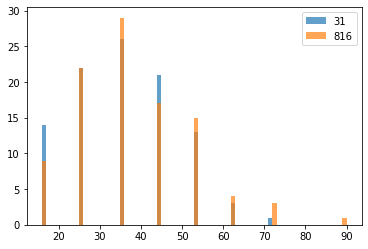

In [228]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(500)
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [216]:
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

Running evaluation: 100%|██████████| 3638/3638 [00:19<00:00, 190.24it/s]

{
    "MSE": 0.31084113696986854,
    "abs_error": 1606.0081822336194,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.678588055005855,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 584.0880128112049,
    "Coverage[0.1]": 0.05360087960417812,
    "QuantileLoss[0.5]": 1606.0081822336194,
    "Coverage[0.5]": 0.1308411214953271,
    "QuantileLoss[0.9]": 1548.7191382936066,
    "Coverage[0.9]": 0.35568993952721273,
    "RMSE": 0.5575312878842483,
    "NRMSE": 0.5515335075939355,
    "ND": 0.4367045500955011,
    "wQuantileLoss[0.1]": 0.15882477790127966,
    "wQuantileLoss[0.5]": 0.4367045500955011,
    "wQuantileLoss[0.9]": 0.42112655588850434,
    "mean_wQuantileLoss": 0.33888529462842837,
    "MAE_Coverage": 0.319956019791094
}


idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 31
idx: 846 t: 14 p: 7
idx: 856 t: 4 p: 0


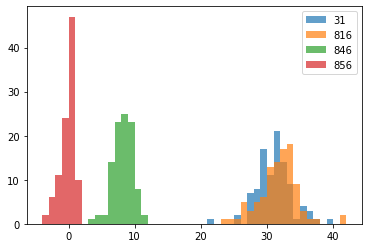

In [217]:
run_test(t[mid], s[mid], [31,816,846,856])

In [219]:
pm, mid = train_model(2000)
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 155.96it/s, avg_epoch_loss=1.22]
INFO:root:Epoch[0] Elapsed time 0.643 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.224804
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 159.95it/s, avg_epoch_loss=0.609]
INFO:root:Epoch[1] Elapsed time 0.627 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.608562
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.66it/s, avg_epoch_loss=0.222]
INFO:root:Epoch[2] Elapsed time 0.620 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.222085
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.88it/s, avg_epoch_loss=0.0678]
INFO:root:Epoch[3] Elapsed time 0.605 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.067834
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.09it

100%|██████████| 100/100 [00:00<00:00, 146.27it/s, avg_epoch_loss=-.117]
INFO:root:Epoch[36] Elapsed time 0.686 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.117225
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 155.76it/s, avg_epoch_loss=-.128]
INFO:root:Epoch[37] Elapsed time 0.644 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.127533
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 159.36it/s, avg_epoch_loss=-.128]
INFO:root:Epoch[38] Elapsed time 0.629 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.127608
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.90it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[39] Elapsed time 0.635 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.132914
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 130.09it/s, avg_epoch_loss=-.103]
INFO:root:Epoch[40] Elapsed tim

100%|██████████| 100/100 [00:00<00:00, 152.87it/s, avg_epoch_loss=-.115]
INFO:root:Epoch[72] Elapsed time 0.656 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.115144
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 148.95it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[73] Elapsed time 0.673 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.139470
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 157.86it/s, avg_epoch_loss=-.112]
INFO:root:Epoch[74] Elapsed time 0.635 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.111878
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 164.90it/s, avg_epoch_loss=-.13]
INFO:root:Epoch[75] Elapsed time 0.608 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.130282
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 145.76it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[76] Elap

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=-0.151207
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.19it/s, avg_epoch_loss=-.113]
INFO:root:Epoch[108] Elapsed time 0.579 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.113449
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.13it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[109] Elapsed time 0.672 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.129241
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 135.37it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[110] Elapsed time 0.740 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.140632
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.30it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[111] Elapsed time 0.596 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.138771
INFO:root:Epoch[112] Learning 

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.24it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[144] Elapsed time 0.611 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.152485
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.14it/s, avg_epoch_loss=-.12]
INFO:root:Epoch[145] Elapsed time 0.618 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.120204
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.62it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[146] Elapsed time 0.624 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.140399
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.13it/s, avg_epoch_loss=-.116]
INFO:root:Epoch[147] Elapsed time 0.661 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.115949
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 140.42it/s,

100%|██████████| 100/100 [00:00<00:00, 183.41it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[180] Elapsed time 0.547 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.156058
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.97it/s, avg_epoch_loss=-.117]
INFO:root:Epoch[181] Elapsed time 0.539 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.116549
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.78it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[182] Elapsed time 0.540 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.125930
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.63it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[183] Elapsed time 0.532 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.143061
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.96it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[184]

100%|██████████| 100/100 [00:00<00:00, 145.85it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[216] Elapsed time 0.689 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.137995
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.91it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[217] Elapsed time 0.658 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.151928
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 137.11it/s, avg_epoch_loss=-.123]
INFO:root:Epoch[218] Elapsed time 0.731 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.122745
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.63it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[219] Elapsed time 0.688 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.137174
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.43it/s, avg_epoch_loss=-.121]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 160.83it/s, avg_epoch_loss=-.12]
INFO:root:Epoch[252] Elapsed time 0.623 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.120433
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.58it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[253] Elapsed time 0.574 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.156614
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.14it/s, avg_epoch_loss=-.118]
INFO:root:Epoch[254] Elapsed time 0.544 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.118389
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.87it/s, avg_epoch_loss=-.128]
INFO:root:Epoch[255] Elapsed time 0.545 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.128415
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.18it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[256]

100%|██████████| 100/100 [00:00<00:00, 147.77it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[288] Elapsed time 0.679 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.131473
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.55it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[289] Elapsed time 0.670 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.137392
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.45it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[290] Elapsed time 0.681 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.157168
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.67it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[291] Elapsed time 0.708 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.124159
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.20it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 143.51it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[324] Elapsed time 0.698 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.137470
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 129.34it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[325] Elapsed time 0.775 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.122426
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 136.32it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[326] Elapsed time 0.735 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.158130
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.01it/s, avg_epoch_loss=-.118]
INFO:root:Epoch[327] Elapsed time 0.586 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.118094
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.53it/s, avg_epoch_loss=-.13]
INFO:root:Epoch[328]

100%|██████████| 100/100 [00:00<00:00, 144.64it/s, avg_epoch_loss=-.123]
INFO:root:Epoch[360] Elapsed time 0.694 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.122549
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 140.75it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[361] Elapsed time 0.712 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.134802
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 124.61it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[362] Elapsed time 0.805 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.141496
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.68it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[363] Elapsed time 0.703 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.154721
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.84it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 150.00it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[396] Elapsed time 0.669 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.148552
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.17it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[397] Elapsed time 0.678 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.138549
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.48it/s, avg_epoch_loss=-.123]
INFO:root:Epoch[398] Elapsed time 0.658 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.123266
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.28it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[399] Elapsed time 0.650 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.158598
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 135.54it/s, avg_epoch_loss=-.12]
INFO:root:Epoch[400]

100%|██████████| 100/100 [00:00<00:00, 164.33it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[432] Elapsed time 0.610 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.144427
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.70it/s, avg_epoch_loss=-.123]
INFO:root:Epoch[433] Elapsed time 0.594 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.123209
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.68it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[434] Elapsed time 0.679 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.134990
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 132.25it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[435] Elapsed time 0.759 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.142844
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.59it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[436

100%|██████████| 100/100 [00:00<00:00, 141.43it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[468] Elapsed time 0.709 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.135221
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.01it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[469] Elapsed time 0.692 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.147995
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.72it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[470] Elapsed time 0.683 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.141183
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 120.80it/s, avg_epoch_loss=-.125]
INFO:root:Epoch[471] Elapsed time 0.830 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.125107
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.20it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[472]

100%|██████████| 100/100 [00:00<00:00, 121.29it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[504] Elapsed time 0.827 seconds
INFO:root:Epoch[504] Evaluation metric 'epoch_loss'=-0.151498
INFO:root:Epoch[505] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 126.82it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[505] Elapsed time 0.791 seconds
INFO:root:Epoch[505] Evaluation metric 'epoch_loss'=-0.145530
INFO:root:Epoch[506] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 125.17it/s, avg_epoch_loss=-.123]
INFO:root:Epoch[506] Elapsed time 0.802 seconds
INFO:root:Epoch[506] Evaluation metric 'epoch_loss'=-0.123482
INFO:root:Epoch[507] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 113.88it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[507] Elapsed time 0.882 seconds
INFO:root:Epoch[507] Evaluation metric 'epoch_loss'=-0.137581
INFO:root:Epoch[508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 123.91it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[508

100%|██████████| 100/100 [00:00<00:00, 158.31it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[540] Elapsed time 0.634 seconds
INFO:root:Epoch[540] Evaluation metric 'epoch_loss'=-0.125657
INFO:root:Epoch[541] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.81it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[541] Elapsed time 0.639 seconds
INFO:root:Epoch[541] Evaluation metric 'epoch_loss'=-0.137441
INFO:root:Epoch[542] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.31it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[542] Elapsed time 0.634 seconds
INFO:root:Epoch[542] Evaluation metric 'epoch_loss'=-0.147637
INFO:root:Epoch[543] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.60it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[543] Elapsed time 0.632 seconds
INFO:root:Epoch[543] Evaluation metric 'epoch_loss'=-0.142308
INFO:root:Epoch[544] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.83it/s, avg_epoch_loss=-.128]
INFO:root:Epoch[544

100%|██████████| 100/100 [00:00<00:00, 155.34it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[576] Elapsed time 0.646 seconds
INFO:root:Epoch[576] Evaluation metric 'epoch_loss'=-0.141036
INFO:root:Epoch[577] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.27it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[577] Elapsed time 0.638 seconds
INFO:root:Epoch[577] Evaluation metric 'epoch_loss'=-0.153061
INFO:root:Epoch[578] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.73it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[578] Elapsed time 0.644 seconds
INFO:root:Epoch[578] Evaluation metric 'epoch_loss'=-0.147400
INFO:root:Epoch[579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.15it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[579] Elapsed time 0.655 seconds
INFO:root:Epoch[579] Evaluation metric 'epoch_loss'=-0.121936
INFO:root:Epoch[580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.05it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[580

100%|██████████| 100/100 [00:00<00:00, 159.22it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[612] Elapsed time 0.630 seconds
INFO:root:Epoch[612] Evaluation metric 'epoch_loss'=-0.145610
INFO:root:Epoch[613] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.57it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[613] Elapsed time 0.637 seconds
INFO:root:Epoch[613] Evaluation metric 'epoch_loss'=-0.126356
INFO:root:Epoch[614] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.05it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[614] Elapsed time 0.706 seconds
INFO:root:Epoch[614] Evaluation metric 'epoch_loss'=-0.139318
INFO:root:Epoch[615] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 138.90it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[615] Elapsed time 0.722 seconds
INFO:root:Epoch[615] Evaluation metric 'epoch_loss'=-0.146802
INFO:root:Epoch[616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.89it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[616

100%|██████████| 100/100 [00:00<00:00, 165.77it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[648] Elapsed time 0.605 seconds
INFO:root:Epoch[648] Evaluation metric 'epoch_loss'=-0.137840
INFO:root:Epoch[649] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.69it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[649] Elapsed time 0.636 seconds
INFO:root:Epoch[649] Evaluation metric 'epoch_loss'=-0.146753
INFO:root:Epoch[650] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 138.29it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[650] Elapsed time 0.725 seconds
INFO:root:Epoch[650] Evaluation metric 'epoch_loss'=-0.147215
INFO:root:Epoch[651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 128.52it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[651] Elapsed time 0.780 seconds
INFO:root:Epoch[651] Evaluation metric 'epoch_loss'=-0.155074
INFO:root:Epoch[652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.83it/s, avg_epoch_loss=-.119]
INFO:root:Epoch[652

100%|██████████| 100/100 [00:00<00:00, 177.74it/s, avg_epoch_loss=-.125]
INFO:root:Epoch[684] Elapsed time 0.564 seconds
INFO:root:Epoch[684] Evaluation metric 'epoch_loss'=-0.124952
INFO:root:Epoch[685] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.93it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[685] Elapsed time 0.604 seconds
INFO:root:Epoch[685] Evaluation metric 'epoch_loss'=-0.148490
INFO:root:Epoch[686] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.55it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[686] Elapsed time 0.595 seconds
INFO:root:Epoch[686] Evaluation metric 'epoch_loss'=-0.121997
INFO:root:Epoch[687] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.63it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[687] Elapsed time 0.636 seconds
INFO:root:Epoch[687] Evaluation metric 'epoch_loss'=-0.141535
INFO:root:Epoch[688] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.90it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[688

100%|██████████| 100/100 [00:00<00:00, 143.43it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[720] Elapsed time 0.701 seconds
INFO:root:Epoch[720] Evaluation metric 'epoch_loss'=-0.122131
INFO:root:Epoch[721] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.42it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[721] Elapsed time 0.709 seconds
INFO:root:Epoch[721] Evaluation metric 'epoch_loss'=-0.138764
INFO:root:Epoch[722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.66it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[722] Elapsed time 0.709 seconds
INFO:root:Epoch[722] Evaluation metric 'epoch_loss'=-0.146763
INFO:root:Epoch[723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.10it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[723] Elapsed time 0.655 seconds
INFO:root:Epoch[723] Evaluation metric 'epoch_loss'=-0.148384
INFO:root:Epoch[724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.48it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[724

100%|██████████| 100/100 [00:00<00:00, 154.09it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[756] Elapsed time 0.651 seconds
INFO:root:Epoch[756] Evaluation metric 'epoch_loss'=-0.161429
INFO:root:Epoch[757] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.52it/s, avg_epoch_loss=-.128]
INFO:root:Epoch[757] Elapsed time 0.649 seconds
INFO:root:Epoch[757] Evaluation metric 'epoch_loss'=-0.127611
INFO:root:Epoch[758] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.27it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[758] Elapsed time 0.650 seconds
INFO:root:Epoch[758] Evaluation metric 'epoch_loss'=-0.146567
INFO:root:Epoch[759] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 140.14it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[759] Elapsed time 0.716 seconds
INFO:root:Epoch[759] Evaluation metric 'epoch_loss'=-0.124431
INFO:root:Epoch[760] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 122.95it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[760

100%|██████████| 100/100 [00:00<00:00, 149.17it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[792] Elapsed time 0.672 seconds
INFO:root:Epoch[792] Evaluation metric 'epoch_loss'=-0.160182
INFO:root:Epoch[793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.78it/s, avg_epoch_loss=-.125]
INFO:root:Epoch[793] Elapsed time 0.621 seconds
INFO:root:Epoch[793] Evaluation metric 'epoch_loss'=-0.124838
INFO:root:Epoch[794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.89it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[794] Elapsed time 0.616 seconds
INFO:root:Epoch[794] Evaluation metric 'epoch_loss'=-0.133650
INFO:root:Epoch[795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.68it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[795] Elapsed time 0.640 seconds
INFO:root:Epoch[795] Evaluation metric 'epoch_loss'=-0.150138
INFO:root:Epoch[796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.32it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[796] E

100%|██████████| 100/100 [00:00<00:00, 148.51it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[828] Elapsed time 0.676 seconds
INFO:root:Epoch[828] Evaluation metric 'epoch_loss'=-0.146207
INFO:root:Epoch[829] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.69it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[829] Elapsed time 0.717 seconds
INFO:root:Epoch[829] Evaluation metric 'epoch_loss'=-0.160673
INFO:root:Epoch[830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.70it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[830] Elapsed time 0.620 seconds
INFO:root:Epoch[830] Evaluation metric 'epoch_loss'=-0.129176
INFO:root:Epoch[831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.98it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[831] Elapsed time 0.635 seconds
INFO:root:Epoch[831] Evaluation metric 'epoch_loss'=-0.143763
INFO:root:Epoch[832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.53it/s, avg_epoch_loss=-.128]
INFO:root:Epoch[832

100%|██████████| 100/100 [00:00<00:00, 155.68it/s, avg_epoch_loss=-.125]
INFO:root:Epoch[864] Elapsed time 0.644 seconds
INFO:root:Epoch[864] Evaluation metric 'epoch_loss'=-0.124851
INFO:root:Epoch[865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.62it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[865] Elapsed time 0.628 seconds
INFO:root:Epoch[865] Evaluation metric 'epoch_loss'=-0.162955
INFO:root:Epoch[866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.63it/s, avg_epoch_loss=-.125]
INFO:root:Epoch[866] Elapsed time 0.640 seconds
INFO:root:Epoch[866] Evaluation metric 'epoch_loss'=-0.125263
INFO:root:Epoch[867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.35it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[867] Elapsed time 0.658 seconds
INFO:root:Epoch[867] Evaluation metric 'epoch_loss'=-0.136836
INFO:root:Epoch[868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.50it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[868]

100%|██████████| 100/100 [00:00<00:00, 128.65it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[900] Elapsed time 0.779 seconds
INFO:root:Epoch[900] Evaluation metric 'epoch_loss'=-0.139047
INFO:root:Epoch[901] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 132.19it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[901] Elapsed time 0.759 seconds
INFO:root:Epoch[901] Evaluation metric 'epoch_loss'=-0.145867
INFO:root:Epoch[902] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.71it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[902] Elapsed time 0.679 seconds
INFO:root:Epoch[902] Evaluation metric 'epoch_loss'=-0.162789
INFO:root:Epoch[903] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.65it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[903] Elapsed time 0.688 seconds
INFO:root:Epoch[903] Evaluation metric 'epoch_loss'=-0.130973
INFO:root:Epoch[904] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 124.76it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[904

100%|██████████| 100/100 [00:00<00:00, 129.01it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[936] Elapsed time 0.778 seconds
INFO:root:Epoch[936] Evaluation metric 'epoch_loss'=-0.144979
INFO:root:Epoch[937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.25it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[937] Elapsed time 0.710 seconds
INFO:root:Epoch[937] Evaluation metric 'epoch_loss'=-0.129056
INFO:root:Epoch[938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.31it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[938] Elapsed time 0.695 seconds
INFO:root:Epoch[938] Evaluation metric 'epoch_loss'=-0.161884
INFO:root:Epoch[939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 131.92it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[939] Elapsed time 0.761 seconds
INFO:root:Epoch[939] Evaluation metric 'epoch_loss'=-0.126130
INFO:root:Epoch[940] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 127.96it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[940

100%|██████████| 100/100 [00:00<00:00, 150.86it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[972] Elapsed time 0.665 seconds
INFO:root:Epoch[972] Evaluation metric 'epoch_loss'=-0.127249
INFO:root:Epoch[973] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 111.27it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[973] Elapsed time 0.901 seconds
INFO:root:Epoch[973] Evaluation metric 'epoch_loss'=-0.142349
INFO:root:Epoch[974] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 125.42it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[974] Elapsed time 0.799 seconds
INFO:root:Epoch[974] Evaluation metric 'epoch_loss'=-0.148393
INFO:root:Epoch[975] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.24it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[975] Elapsed time 0.622 seconds
INFO:root:Epoch[975] Evaluation metric 'epoch_loss'=-0.163270
INFO:root:Epoch[976] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.01it/s, avg_epoch_loss=-.13]
INFO:root:Epoch[976]

100%|██████████| 100/100 [00:00<00:00, 128.84it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1008] Elapsed time 0.778 seconds
INFO:root:Epoch[1008] Evaluation metric 'epoch_loss'=-0.154691
INFO:root:Epoch[1009] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.56it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1009] Elapsed time 0.653 seconds
INFO:root:Epoch[1009] Evaluation metric 'epoch_loss'=-0.145918
INFO:root:Epoch[1010] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.65it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[1010] Elapsed time 0.653 seconds
INFO:root:Epoch[1010] Evaluation metric 'epoch_loss'=-0.128762
INFO:root:Epoch[1011] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.15it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[1011] Elapsed time 0.691 seconds
INFO:root:Epoch[1011] Evaluation metric 'epoch_loss'=-0.162478
INFO:root:Epoch[1012] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 140.17it/s, avg_epoch_loss=-.127]
INFO:ro

INFO:root:Epoch[1044] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.33it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[1044] Elapsed time 0.659 seconds
INFO:root:Epoch[1044] Evaluation metric 'epoch_loss'=-0.150817
INFO:root:Epoch[1045] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.21it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[1045] Elapsed time 0.686 seconds
INFO:root:Epoch[1045] Evaluation metric 'epoch_loss'=-0.129109
INFO:root:Epoch[1046] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.26it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1046] Elapsed time 0.672 seconds
INFO:root:Epoch[1046] Evaluation metric 'epoch_loss'=-0.143719
INFO:root:Epoch[1047] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.09it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[1047] Elapsed time 0.623 seconds
INFO:root:Epoch[1047] Evaluation metric 'epoch_loss'=-0.150225
INFO:root:Epoch[1048] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1079] Evaluation metric 'epoch_loss'=-0.135152
INFO:root:Epoch[1080] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.63it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1080] Elapsed time 0.693 seconds
INFO:root:Epoch[1080] Evaluation metric 'epoch_loss'=-0.141475
INFO:root:Epoch[1081] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.83it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1081] Elapsed time 0.702 seconds
INFO:root:Epoch[1081] Evaluation metric 'epoch_loss'=-0.155013
INFO:root:Epoch[1082] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.59it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[1082] Elapsed time 0.690 seconds
INFO:root:Epoch[1082] Evaluation metric 'epoch_loss'=-0.149918
INFO:root:Epoch[1083] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 129.89it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[1083] Elapsed time 0.772 seconds
INFO:root:Epoch[1083] Evaluation metric 'epoch_loss'=-0.131494
INFO:root:Epoch[10

100%|██████████| 100/100 [00:00<00:00, 142.53it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1115] Elapsed time 0.704 seconds
INFO:root:Epoch[1115] Evaluation metric 'epoch_loss'=-0.147156
INFO:root:Epoch[1116] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.96it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1116] Elapsed time 0.698 seconds
INFO:root:Epoch[1116] Evaluation metric 'epoch_loss'=-0.160439
INFO:root:Epoch[1117] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 136.70it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[1117] Elapsed time 0.734 seconds
INFO:root:Epoch[1117] Evaluation metric 'epoch_loss'=-0.151259
INFO:root:Epoch[1118] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 138.31it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[1118] Elapsed time 0.725 seconds
INFO:root:Epoch[1118] Evaluation metric 'epoch_loss'=-0.130723
INFO:root:Epoch[1119] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 137.88it/s, avg_epoch_loss=-.147]
INFO:roo

INFO:root:Epoch[1151] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 134.05it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[1151] Elapsed time 0.748 seconds
INFO:root:Epoch[1151] Evaluation metric 'epoch_loss'=-0.148482
INFO:root:Epoch[1152] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 129.81it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[1152] Elapsed time 0.773 seconds
INFO:root:Epoch[1152] Evaluation metric 'epoch_loss'=-0.133434
INFO:root:Epoch[1153] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 127.04it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1153] Elapsed time 0.790 seconds
INFO:root:Epoch[1153] Evaluation metric 'epoch_loss'=-0.145898
INFO:root:Epoch[1154] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 121.85it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1154] Elapsed time 0.823 seconds
INFO:root:Epoch[1154] Evaluation metric 'epoch_loss'=-0.155118
INFO:root:Epoch[1155] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1186] Evaluation metric 'epoch_loss'=-0.131433
INFO:root:Epoch[1187] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.98it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1187] Elapsed time 0.580 seconds
INFO:root:Epoch[1187] Evaluation metric 'epoch_loss'=-0.146612
INFO:root:Epoch[1188] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.36it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1188] Elapsed time 0.572 seconds
INFO:root:Epoch[1188] Evaluation metric 'epoch_loss'=-0.146548
INFO:root:Epoch[1189] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.07it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[1189] Elapsed time 0.563 seconds
INFO:root:Epoch[1189] Evaluation metric 'epoch_loss'=-0.161397
INFO:root:Epoch[1190] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.48it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1190] Elapsed time 0.582 seconds
INFO:root:Epoch[1190] Evaluation metric 'epoch_loss'=-0.153918
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 149.32it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[1222] Elapsed time 0.672 seconds
INFO:root:Epoch[1222] Evaluation metric 'epoch_loss'=-0.165985
INFO:root:Epoch[1223] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.97it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[1223] Elapsed time 0.627 seconds
INFO:root:Epoch[1223] Evaluation metric 'epoch_loss'=-0.133678
INFO:root:Epoch[1224] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.93it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1224] Elapsed time 0.635 seconds
INFO:root:Epoch[1224] Evaluation metric 'epoch_loss'=-0.151931
INFO:root:Epoch[1225] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.62it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[1225] Elapsed time 0.632 seconds
INFO:root:Epoch[1225] Evaluation metric 'epoch_loss'=-0.133761
INFO:root:Epoch[1226] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.67it/s, avg_epoch_loss=-.148]
INFO:ro

INFO:root:Epoch[1258] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.02it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1258] Elapsed time 0.677 seconds
INFO:root:Epoch[1258] Evaluation metric 'epoch_loss'=-0.164856
INFO:root:Epoch[1259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.01it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[1259] Elapsed time 0.659 seconds
INFO:root:Epoch[1259] Evaluation metric 'epoch_loss'=-0.129251
INFO:root:Epoch[1260] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 129.21it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1260] Elapsed time 0.776 seconds
INFO:root:Epoch[1260] Evaluation metric 'epoch_loss'=-0.146044
INFO:root:Epoch[1261] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.70it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1261] Elapsed time 0.649 seconds
INFO:root:Epoch[1261] Evaluation metric 'epoch_loss'=-0.152047
INFO:root:Epoch[1262] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1293] Evaluation metric 'epoch_loss'=-0.139384
INFO:root:Epoch[1294] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.17it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1294] Elapsed time 0.583 seconds
INFO:root:Epoch[1294] Evaluation metric 'epoch_loss'=-0.153904
INFO:root:Epoch[1295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.76it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1295] Elapsed time 0.546 seconds
INFO:root:Epoch[1295] Evaluation metric 'epoch_loss'=-0.167220
INFO:root:Epoch[1296] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.24it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[1296] Elapsed time 0.560 seconds
INFO:root:Epoch[1296] Evaluation metric 'epoch_loss'=-0.133045
INFO:root:Epoch[1297] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.95it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1297] Elapsed time 0.576 seconds
INFO:root:Epoch[1297] Evaluation metric 'epoch_loss'=-0.155218
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 170.31it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[1329] Elapsed time 0.589 seconds
INFO:root:Epoch[1329] Evaluation metric 'epoch_loss'=-0.151213
INFO:root:Epoch[1330] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.12it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[1330] Elapsed time 0.586 seconds
INFO:root:Epoch[1330] Evaluation metric 'epoch_loss'=-0.134519
INFO:root:Epoch[1331] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.63it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[1331] Elapsed time 0.561 seconds
INFO:root:Epoch[1331] Evaluation metric 'epoch_loss'=-0.165653
INFO:root:Epoch[1332] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.27it/s, avg_epoch_loss=-.13]
INFO:root:Epoch[1332] Elapsed time 0.582 seconds
INFO:root:Epoch[1332] Evaluation metric 'epoch_loss'=-0.129545
INFO:root:Epoch[1333] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.80it/s, avg_epoch_loss=-.146]
INFO:roo

INFO:root:Epoch[1365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.01it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[1365] Elapsed time 0.593 seconds
INFO:root:Epoch[1365] Evaluation metric 'epoch_loss'=-0.142733
INFO:root:Epoch[1366] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.53it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1366] Elapsed time 0.584 seconds
INFO:root:Epoch[1366] Evaluation metric 'epoch_loss'=-0.141144
INFO:root:Epoch[1367] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.93it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1367] Elapsed time 0.583 seconds
INFO:root:Epoch[1367] Evaluation metric 'epoch_loss'=-0.154676
INFO:root:Epoch[1368] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.77it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1368] Elapsed time 0.591 seconds
INFO:root:Epoch[1368] Evaluation metric 'epoch_loss'=-0.166967
INFO:root:Epoch[1369] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1400] Evaluation metric 'epoch_loss'=-0.138791
INFO:root:Epoch[1401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.28it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1401] Elapsed time 0.638 seconds
INFO:root:Epoch[1401] Evaluation metric 'epoch_loss'=-0.164259
INFO:root:Epoch[1402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.39it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1402] Elapsed time 0.629 seconds
INFO:root:Epoch[1402] Evaluation metric 'epoch_loss'=-0.152080
INFO:root:Epoch[1403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.68it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[1403] Elapsed time 0.628 seconds
INFO:root:Epoch[1403] Evaluation metric 'epoch_loss'=-0.132696
INFO:root:Epoch[1404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.25it/s, avg_epoch_loss=-.168]
INFO:root:Epoch[1404] Elapsed time 0.630 seconds
INFO:root:Epoch[1404] Evaluation metric 'epoch_loss'=-0.167641
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 179.39it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1436] Elapsed time 0.559 seconds
INFO:root:Epoch[1436] Evaluation metric 'epoch_loss'=-0.165047
INFO:root:Epoch[1437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.57it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[1437] Elapsed time 0.558 seconds
INFO:root:Epoch[1437] Evaluation metric 'epoch_loss'=-0.148346
INFO:root:Epoch[1438] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.83it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[1438] Elapsed time 0.564 seconds
INFO:root:Epoch[1438] Evaluation metric 'epoch_loss'=-0.142112
INFO:root:Epoch[1439] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.49it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1439] Elapsed time 0.555 seconds
INFO:root:Epoch[1439] Evaluation metric 'epoch_loss'=-0.144723
INFO:root:Epoch[1440] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.53it/s, avg_epoch_loss=-.154]
INFO:ro

INFO:root:Epoch[1472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.19it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1472] Elapsed time 0.563 seconds
INFO:root:Epoch[1472] Evaluation metric 'epoch_loss'=-0.140149
INFO:root:Epoch[1473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.20it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[1473] Elapsed time 0.579 seconds
INFO:root:Epoch[1473] Evaluation metric 'epoch_loss'=-0.139295
INFO:root:Epoch[1474] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.60it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1474] Elapsed time 0.581 seconds
INFO:root:Epoch[1474] Evaluation metric 'epoch_loss'=-0.164731
INFO:root:Epoch[1475] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.98it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1475] Elapsed time 0.576 seconds
INFO:root:Epoch[1475] Evaluation metric 'epoch_loss'=-0.152728
INFO:root:Epoch[1476] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1507] Evaluation metric 'epoch_loss'=-0.153368
INFO:root:Epoch[1508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.45it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1508] Elapsed time 0.572 seconds
INFO:root:Epoch[1508] Evaluation metric 'epoch_loss'=-0.145269
INFO:root:Epoch[1509] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.33it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1509] Elapsed time 0.575 seconds
INFO:root:Epoch[1509] Evaluation metric 'epoch_loss'=-0.163998
INFO:root:Epoch[1510] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.63it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1510] Elapsed time 0.574 seconds
INFO:root:Epoch[1510] Evaluation metric 'epoch_loss'=-0.153277
INFO:root:Epoch[1511] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.28it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[1511] Elapsed time 0.579 seconds
INFO:root:Epoch[1511] Evaluation metric 'epoch_loss'=-0.137173
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 173.61it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1543] Elapsed time 0.578 seconds
INFO:root:Epoch[1543] Evaluation metric 'epoch_loss'=-0.141189
INFO:root:Epoch[1544] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.66it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1544] Elapsed time 0.564 seconds
INFO:root:Epoch[1544] Evaluation metric 'epoch_loss'=-0.156589
INFO:root:Epoch[1545] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.88it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[1545] Elapsed time 0.583 seconds
INFO:root:Epoch[1545] Evaluation metric 'epoch_loss'=-0.137942
INFO:root:Epoch[1546] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.20it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1546] Elapsed time 0.579 seconds
INFO:root:Epoch[1546] Evaluation metric 'epoch_loss'=-0.143986
INFO:root:Epoch[1547] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.71it/s, avg_epoch_loss=-.163]
INFO:ro

INFO:root:Epoch[1579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.22it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[1579] Elapsed time 0.622 seconds
INFO:root:Epoch[1579] Evaluation metric 'epoch_loss'=-0.134109
INFO:root:Epoch[1580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.43it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[1580] Elapsed time 0.581 seconds
INFO:root:Epoch[1580] Evaluation metric 'epoch_loss'=-0.151440
INFO:root:Epoch[1581] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.32it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1581] Elapsed time 0.569 seconds
INFO:root:Epoch[1581] Evaluation metric 'epoch_loss'=-0.147387
INFO:root:Epoch[1582] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.64it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[1582] Elapsed time 0.577 seconds
INFO:root:Epoch[1582] Evaluation metric 'epoch_loss'=-0.165731
INFO:root:Epoch[1583] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1614] Evaluation metric 'epoch_loss'=-0.155254
INFO:root:Epoch[1615] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.61it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1615] Elapsed time 0.562 seconds
INFO:root:Epoch[1615] Evaluation metric 'epoch_loss'=-0.164564
INFO:root:Epoch[1616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.02it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[1616] Elapsed time 0.619 seconds
INFO:root:Epoch[1616] Evaluation metric 'epoch_loss'=-0.142627
INFO:root:Epoch[1617] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.48it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1617] Elapsed time 0.653 seconds
INFO:root:Epoch[1617] Evaluation metric 'epoch_loss'=-0.155071
INFO:root:Epoch[1618] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.44it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[1618] Elapsed time 0.694 seconds
INFO:root:Epoch[1618] Evaluation metric 'epoch_loss'=-0.138067
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 178.38it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1650] Elapsed time 0.562 seconds
INFO:root:Epoch[1650] Evaluation metric 'epoch_loss'=-0.143909
INFO:root:Epoch[1651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.45it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1651] Elapsed time 0.559 seconds
INFO:root:Epoch[1651] Evaluation metric 'epoch_loss'=-0.159643
INFO:root:Epoch[1652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.78it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[1652] Elapsed time 0.627 seconds
INFO:root:Epoch[1652] Evaluation metric 'epoch_loss'=-0.134060
INFO:root:Epoch[1653] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 145.97it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1653] Elapsed time 0.687 seconds
INFO:root:Epoch[1653] Evaluation metric 'epoch_loss'=-0.152359
INFO:root:Epoch[1654] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.54it/s, avg_epoch_loss=-.151]
INFO:roo

INFO:root:Epoch[1686] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.28it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1686] Elapsed time 0.638 seconds
INFO:root:Epoch[1686] Evaluation metric 'epoch_loss'=-0.147143
INFO:root:Epoch[1687] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.38it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1687] Elapsed time 0.618 seconds
INFO:root:Epoch[1687] Evaluation metric 'epoch_loss'=-0.153622
INFO:root:Epoch[1688] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.17it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1688] Elapsed time 0.607 seconds
INFO:root:Epoch[1688] Evaluation metric 'epoch_loss'=-0.166633
INFO:root:Epoch[1689] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.44it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1689] Elapsed time 0.641 seconds
INFO:root:Epoch[1689] Evaluation metric 'epoch_loss'=-0.140616
INFO:root:Epoch[1690] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1721] Evaluation metric 'epoch_loss'=-0.159960
INFO:root:Epoch[1722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.38it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[1722] Elapsed time 0.621 seconds
INFO:root:Epoch[1722] Evaluation metric 'epoch_loss'=-0.151084
INFO:root:Epoch[1723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.02it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[1723] Elapsed time 0.623 seconds
INFO:root:Epoch[1723] Evaluation metric 'epoch_loss'=-0.142546
INFO:root:Epoch[1724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.43it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[1724] Elapsed time 0.637 seconds
INFO:root:Epoch[1724] Evaluation metric 'epoch_loss'=-0.162122
INFO:root:Epoch[1725] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.09it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[1725] Elapsed time 0.664 seconds
INFO:root:Epoch[1725] Evaluation metric 'epoch_loss'=-0.136151
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 187.63it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1757] Elapsed time 0.534 seconds
INFO:root:Epoch[1757] Evaluation metric 'epoch_loss'=-0.148622
INFO:root:Epoch[1758] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.20it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1758] Elapsed time 0.544 seconds
INFO:root:Epoch[1758] Evaluation metric 'epoch_loss'=-0.145803
INFO:root:Epoch[1759] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.74it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[1759] Elapsed time 0.546 seconds
INFO:root:Epoch[1759] Evaluation metric 'epoch_loss'=-0.147668
INFO:root:Epoch[1760] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.12it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1760] Elapsed time 0.541 seconds
INFO:root:Epoch[1760] Evaluation metric 'epoch_loss'=-0.157385
INFO:root:Epoch[1761] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.78it/s, avg_epoch_loss=-.166]
INFO:ro

INFO:root:Epoch[1793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.55it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1793] Elapsed time 0.565 seconds
INFO:root:Epoch[1793] Evaluation metric 'epoch_loss'=-0.152174
INFO:root:Epoch[1794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.82it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[1794] Elapsed time 0.577 seconds
INFO:root:Epoch[1794] Evaluation metric 'epoch_loss'=-0.161521
INFO:root:Epoch[1795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.54it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[1795] Elapsed time 0.585 seconds
INFO:root:Epoch[1795] Evaluation metric 'epoch_loss'=-0.150671
INFO:root:Epoch[1796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.23it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1796] Elapsed time 0.596 seconds
INFO:root:Epoch[1796] Evaluation metric 'epoch_loss'=-0.141465
INFO:root:Epoch[1797] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1828] Evaluation metric 'epoch_loss'=-0.144530
INFO:root:Epoch[1829] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.12it/s, avg_epoch_loss=-.168]
INFO:root:Epoch[1829] Elapsed time 0.597 seconds
INFO:root:Epoch[1829] Evaluation metric 'epoch_loss'=-0.167692
INFO:root:Epoch[1830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.70it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1830] Elapsed time 0.609 seconds
INFO:root:Epoch[1830] Evaluation metric 'epoch_loss'=-0.152818
INFO:root:Epoch[1831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.62it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1831] Elapsed time 0.575 seconds
INFO:root:Epoch[1831] Evaluation metric 'epoch_loss'=-0.147012
INFO:root:Epoch[1832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.95it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1832] Elapsed time 0.587 seconds
INFO:root:Epoch[1832] Evaluation metric 'epoch_loss'=-0.146493
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 176.15it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1864] Elapsed time 0.569 seconds
INFO:root:Epoch[1864] Evaluation metric 'epoch_loss'=-0.159306
INFO:root:Epoch[1865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.04it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1865] Elapsed time 0.567 seconds
INFO:root:Epoch[1865] Evaluation metric 'epoch_loss'=-0.146420
INFO:root:Epoch[1866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.24it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[1866] Elapsed time 0.556 seconds
INFO:root:Epoch[1866] Evaluation metric 'epoch_loss'=-0.150857
INFO:root:Epoch[1867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.69it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[1867] Elapsed time 0.568 seconds
INFO:root:Epoch[1867] Evaluation metric 'epoch_loss'=-0.161463
INFO:root:Epoch[1868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.12it/s, avg_epoch_loss=-.153]
INFO:ro

INFO:root:Epoch[1900] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.83it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1900] Elapsed time 0.561 seconds
INFO:root:Epoch[1900] Evaluation metric 'epoch_loss'=-0.158589
INFO:root:Epoch[1901] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.41it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1901] Elapsed time 0.565 seconds
INFO:root:Epoch[1901] Evaluation metric 'epoch_loss'=-0.146881
INFO:root:Epoch[1902] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.61it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[1902] Elapsed time 0.571 seconds
INFO:root:Epoch[1902] Evaluation metric 'epoch_loss'=-0.168781
INFO:root:Epoch[1903] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.66it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1903] Elapsed time 0.577 seconds
INFO:root:Epoch[1903] Evaluation metric 'epoch_loss'=-0.151715
INFO:root:Epoch[1904] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1935] Evaluation metric 'epoch_loss'=-0.167297
INFO:root:Epoch[1936] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.41it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[1936] Elapsed time 0.589 seconds
INFO:root:Epoch[1936] Evaluation metric 'epoch_loss'=-0.135742
INFO:root:Epoch[1937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.08it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[1937] Elapsed time 0.607 seconds
INFO:root:Epoch[1937] Evaluation metric 'epoch_loss'=-0.163253
INFO:root:Epoch[1938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.87it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[1938] Elapsed time 0.605 seconds
INFO:root:Epoch[1938] Evaluation metric 'epoch_loss'=-0.142499
INFO:root:Epoch[1939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.92it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[1939] Elapsed time 0.597 seconds
INFO:root:Epoch[1939] Evaluation metric 'epoch_loss'=-0.147769
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 165.01it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1971] Elapsed time 0.608 seconds
INFO:root:Epoch[1971] Evaluation metric 'epoch_loss'=-0.153852
INFO:root:Epoch[1972] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.32it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[1972] Elapsed time 0.614 seconds
INFO:root:Epoch[1972] Evaluation metric 'epoch_loss'=-0.137173
INFO:root:Epoch[1973] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.50it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1973] Elapsed time 0.666 seconds
INFO:root:Epoch[1973] Evaluation metric 'epoch_loss'=-0.158027
INFO:root:Epoch[1974] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.73it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1974] Elapsed time 0.616 seconds
INFO:root:Epoch[1974] Evaluation metric 'epoch_loss'=-0.148921
INFO:root:Epoch[1975] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.18it/s, avg_epoch_loss=-.166]
INFO:ro

{
    "MSE": 0.3041607122261287,
    "abs_error": 1572.649736486167,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6704229932665697,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 587.0753362472221,
    "Coverage[0.1]": 0.052776250687190766,
    "QuantileLoss[0.5]": 1572.649736486167,
    "Coverage[0.5]": 0.13881253435953822,
    "QuantileLoss[0.9]": 1528.8371478151803,
    "Coverage[0.9]": 0.36943375481033536,
    "RMSE": 0.5515076719558203,
    "NRMSE": 0.5455746921989968,
    "ND": 0.42763374634544443,
    "wQuantileLoss[0.1]": 0.15963708866753074,
    "wQuantileLoss[0.5]": 0.42763374634544443,
    "wQuantileLoss[0.9]": 0.4157202598291601,
    "mean_wQuantileLoss": 0.3343303649473784,
    "MAE_Coverage": 0.3129924867143119
}


In [220]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 196.36it/s, avg_epoch_loss=1.22]
INFO:root:Epoch[0] Elapsed time 0.511 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.215777
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 192.51it/s, avg_epoch_loss=0.405]
INFO:root:Epoch[1] Elapsed time 0.521 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.405416
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.39it/s, avg_epoch_loss=0.0627]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.062685
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 196.71it/s, avg_epoch_loss=-.0138]
INFO:root:Epoch[3] Elapsed time 0.510 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.013815
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 197.39

100%|██████████| 100/100 [00:00<00:00, 195.15it/s, avg_epoch_loss=-.109]
INFO:root:Epoch[36] Elapsed time 0.514 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.108623
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 199.92it/s, avg_epoch_loss=-.121]
INFO:root:Epoch[37] Elapsed time 0.502 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.120859
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 199.60it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[38] Elapsed time 0.502 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.121565
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 193.65it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[39] Elapsed time 0.518 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.122051
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 195.68it/s, avg_epoch_loss=-.0931]
INFO:root:Epoch[40] Elapsed ti

100%|██████████| 100/100 [00:00<00:00, 200.15it/s, avg_epoch_loss=-.105]
INFO:root:Epoch[72] Elapsed time 0.501 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.104554
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 198.27it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[73] Elapsed time 0.506 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.127186
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 197.96it/s, avg_epoch_loss=-.1]
INFO:root:Epoch[74] Elapsed time 0.507 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.100305
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 197.63it/s, avg_epoch_loss=-.119]
INFO:root:Epoch[75] Elapsed time 0.507 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.118705
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 198.67i

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=-0.134551
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.20it/s, avg_epoch_loss=-.102]
INFO:root:Epoch[108] Elapsed time 0.527 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.101836
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.11it/s, avg_epoch_loss=-.115]
INFO:root:Epoch[109] Elapsed time 0.536 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.115406
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.09it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[110] Elapsed time 0.536 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.129130
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.49it/s, avg_epoch_loss=-.128]
INFO:root:Epoch[111] Elapsed time 0.529 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.128102
INFO:root:Epoch[112] Learning 

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.28it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[144] Elapsed time 0.569 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.140077
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.00it/s, avg_epoch_loss=-.108]
INFO:root:Epoch[145] Elapsed time 0.563 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.107636
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.19it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[146] Elapsed time 0.580 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.126387
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.18it/s, avg_epoch_loss=-.103]
INFO:root:Epoch[147] Elapsed time 0.527 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.103117
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.79it/s

100%|██████████| 100/100 [00:00<00:00, 205.17it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[180] Elapsed time 0.489 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.138800
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 207.56it/s, avg_epoch_loss=-.105]
INFO:root:Epoch[181] Elapsed time 0.483 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.105065
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.21it/s, avg_epoch_loss=-.112]
INFO:root:Epoch[182] Elapsed time 0.491 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.111730
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 209.53it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[183] Elapsed time 0.479 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.131185
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 207.15it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 189.11it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[216] Elapsed time 0.531 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.123764
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.11it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[217] Elapsed time 0.551 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.138814
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.41it/s, avg_epoch_loss=-.11]
INFO:root:Epoch[218] Elapsed time 0.529 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.109925
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.09it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[219] Elapsed time 0.533 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.123977
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.17it/s, avg_epoch_loss=-.108]
INFO:root:Epoch[220]

100%|██████████| 100/100 [00:00<00:00, 186.32it/s, avg_epoch_loss=-.11]
INFO:root:Epoch[252] Elapsed time 0.538 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.109518
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.10it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[253] Elapsed time 0.536 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.139240
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.38it/s, avg_epoch_loss=-.107]
INFO:root:Epoch[254] Elapsed time 0.535 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.107293
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.73it/s, avg_epoch_loss=-.114]
INFO:root:Epoch[255] Elapsed time 0.543 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.114403
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.85it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[256]

100%|██████████| 100/100 [00:00<00:00, 192.30it/s, avg_epoch_loss=-.121]
INFO:root:Epoch[288] Elapsed time 0.521 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.121051
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 195.01it/s, avg_epoch_loss=-.122]
INFO:root:Epoch[289] Elapsed time 0.514 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.122384
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.05it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[290] Elapsed time 0.522 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.143885
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.55it/s, avg_epoch_loss=-.111]
INFO:root:Epoch[291] Elapsed time 0.518 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.111064
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 196.23it/s, avg_epoch_loss=-.123]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 195.47it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[324] Elapsed time 0.513 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.125644
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.08it/s, avg_epoch_loss=-.111]
INFO:root:Epoch[325] Elapsed time 0.522 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.111029
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.60it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[326] Elapsed time 0.521 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.140301
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 195.81it/s, avg_epoch_loss=-.108]
INFO:root:Epoch[327] Elapsed time 0.512 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.108004
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 198.81it/s, avg_epoch_loss=-.116]
INFO:root:Epoch[328]

100%|██████████| 100/100 [00:00<00:00, 197.00it/s, avg_epoch_loss=-.109]
INFO:root:Epoch[360] Elapsed time 0.509 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.108526
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 196.25it/s, avg_epoch_loss=-.123]
INFO:root:Epoch[361] Elapsed time 0.511 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.123454
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.57it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[362] Elapsed time 0.562 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.127094
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.17it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[363] Elapsed time 0.548 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.141456
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.84it/s, avg_epoch_loss=-.112]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 181.27it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[396] Elapsed time 0.553 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.133052
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.92it/s, avg_epoch_loss=-.126]
INFO:root:Epoch[397] Elapsed time 0.647 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.126193
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.03it/s, avg_epoch_loss=-.112]
INFO:root:Epoch[398] Elapsed time 0.596 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.111709
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.13it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[399] Elapsed time 0.554 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.141110
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.25it/s, avg_epoch_loss=-.109]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 209.07it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[432] Elapsed time 0.480 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.129238
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 202.95it/s, avg_epoch_loss=-.11]
INFO:root:Epoch[433] Elapsed time 0.494 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.109808
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 202.47it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[434] Elapsed time 0.495 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.123562
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 199.25it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[435] Elapsed time 0.503 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.127392
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 207.88it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[436]

100%|██████████| 100/100 [00:00<00:00, 210.04it/s, avg_epoch_loss=-.124]
INFO:root:Epoch[468] Elapsed time 0.477 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.123678
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 203.81it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[469] Elapsed time 0.492 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.131847
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 205.16it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[470] Elapsed time 0.489 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.129257
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 205.08it/s, avg_epoch_loss=-.113]
INFO:root:Epoch[471] Elapsed time 0.489 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.113152
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 204.11it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[472

{
    "MSE": 0.3086568233792749,
    "abs_error": 1585.2765641315914,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6669529076483897,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 603.7919668483962,
    "Coverage[0.1]": 0.049752611324903794,
    "QuantileLoss[0.5]": 1585.2765641315914,
    "Coverage[0.5]": 0.13551401869158877,
    "QuantileLoss[0.9]": 1493.2853354795673,
    "Coverage[0.9]": 0.3633864760857614,
    "RMSE": 0.55556891865841,
    "NRMSE": 0.5495922490388716,
    "ND": 0.4310672239248422,
    "wQuantileLoss[0.1]": 0.16418266242397656,
    "wQuantileLoss[0.5]": 0.4310672239248422,
    "wQuantileLoss[0.9]": 0.40605303746824367,
    "mean_wQuantileLoss": 0.3337676412723541,
    "MAE_Coverage": 0.3171156312992487
}


In [221]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.67it/s, avg_epoch_loss=0.726]
INFO:root:Epoch[0] Elapsed time 0.624 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.725802
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.55it/s, avg_epoch_loss=0.00447]
INFO:root:Epoch[1] Elapsed time 0.609 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.004470
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.78it/s, avg_epoch_loss=-.0506]
INFO:root:Epoch[2] Elapsed time 0.601 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.050599
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.83it/s, avg_epoch_loss=-.0707]
INFO:root:Epoch[3] Elapsed time 0.587 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.070750
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 16

100%|██████████| 100/100 [00:00<00:00, 153.30it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[36] Elapsed time 0.654 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.136878
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.84it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[37] Elapsed time 0.635 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.148723
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.86it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[38] Elapsed time 0.635 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.141253
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 158.23it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[39] Elapsed time 0.634 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.154900
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 126.93it/s, avg_epoch_loss=-.121]
INFO:root:Epoch[40] Elapsed tim

100%|██████████| 100/100 [00:00<00:00, 147.41it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[72] Elapsed time 0.681 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.138561
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 175.69it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[73] Elapsed time 0.571 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.160194
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 176.00it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[74] Elapsed time 0.569 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.135762
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 174.13it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[75] Elapsed time 0.576 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.155547
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 173.47it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[76] Elap

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=-0.173011
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.17it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[108] Elapsed time 0.663 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.143384
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.96it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[109] Elapsed time 0.682 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.155437
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.58it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[110] Elapsed time 0.693 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.163237
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.08it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[111] Elapsed time 0.681 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.164873
INFO:root:Epoch[112] Learning 

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.06it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[144] Elapsed time 0.611 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.175020
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.86it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[145] Elapsed time 0.597 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.145581
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.42it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[146] Elapsed time 0.610 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.161470
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.65it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[147] Elapsed time 0.616 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.142723
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.98it/

100%|██████████| 100/100 [00:00<00:00, 174.75it/s, avg_epoch_loss=-.177]
INFO:root:Epoch[180] Elapsed time 0.574 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.176804
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.10it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[181] Elapsed time 0.572 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.147252
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.22it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[182] Elapsed time 0.578 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.151850
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.58it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[183] Elapsed time 0.577 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.165696
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.69it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 165.62it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[216] Elapsed time 0.605 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.166183
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.67it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[217] Elapsed time 0.624 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.174758
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.54it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[218] Elapsed time 0.703 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.148884
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.13it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[219] Elapsed time 0.720 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.157912
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.65it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 170.27it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[252] Elapsed time 0.589 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.145553
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.31it/s, avg_epoch_loss=-.178]
INFO:root:Epoch[253] Elapsed time 0.603 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.177522
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.25it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[254] Elapsed time 0.575 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.148904
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.17it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[255] Elapsed time 0.582 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.154066
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.41it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[256

100%|██████████| 100/100 [00:00<00:00, 154.45it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[288] Elapsed time 0.649 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.159071
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.34it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[289] Elapsed time 0.671 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.165467
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.85it/s, avg_epoch_loss=-.179]
INFO:root:Epoch[290] Elapsed time 0.702 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.179472
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.75it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[291] Elapsed time 0.693 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.150026
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 144.21it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[292]

100%|██████████| 100/100 [00:00<00:00, 175.39it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[324] Elapsed time 0.571 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.161508
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.99it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[325] Elapsed time 0.570 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.147994
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.24it/s, avg_epoch_loss=-.179]
INFO:root:Epoch[326] Elapsed time 0.565 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.179328
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.32it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[327] Elapsed time 0.582 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.148606
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.53it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[328

100%|██████████| 100/100 [00:00<00:00, 166.29it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[360] Elapsed time 0.603 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.145826
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.73it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[361] Elapsed time 0.609 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.162190
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.75it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[362] Elapsed time 0.616 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.168816
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.53it/s, avg_epoch_loss=-.177]
INFO:root:Epoch[363] Elapsed time 0.602 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.177240
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.36it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 155.44it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[396] Elapsed time 0.645 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.171594
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.93it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[397] Elapsed time 0.611 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.163440
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.42it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[398] Elapsed time 0.613 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.149108
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.82it/s, avg_epoch_loss=-.179]
INFO:root:Epoch[399] Elapsed time 0.612 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.179186
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.35it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 170.37it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[432] Elapsed time 0.588 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.166707
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.92it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[433] Elapsed time 0.608 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.146690
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.86it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[434] Elapsed time 0.604 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.161174
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.25it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[435] Elapsed time 0.603 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.169871
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.51it/s, avg_epoch_loss=-.178]
INFO:root:Epoch[436]

100%|██████████| 100/100 [00:00<00:00, 154.76it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[468] Elapsed time 0.648 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.163091
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.24it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[469] Elapsed time 0.638 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.170660
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.22it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[470] Elapsed time 0.630 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.166068
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.88it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[471] Elapsed time 0.639 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.150666
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.99it/s, avg_epoch_loss=-.181]
INFO:root:Epoch[472

{
    "MSE": 0.2981205094327549,
    "abs_error": 1540.1938594877683,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6685573749687055,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 613.0507080137261,
    "Coverage[0.1]": 0.06926882902693787,
    "QuantileLoss[0.5]": 1540.1938594877683,
    "Coverage[0.5]": 0.15228147333699835,
    "QuantileLoss[0.9]": 1455.6545566663103,
    "Coverage[0.9]": 0.38235294117647056,
    "RMSE": 0.5460041295015587,
    "NRMSE": 0.5401303554596008,
    "ND": 0.4188083684181489,
    "wQuantileLoss[0.1]": 0.166700292433453,
    "wQuantileLoss[0.5]": 0.4188083684181489,
    "wQuantileLoss[0.9]": 0.3958205040894093,
    "mean_wQuantileLoss": 0.32710972164700375,
    "MAE_Coverage": 0.2986989188198644
}


idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 30
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 0


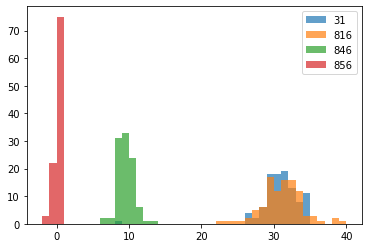

In [222]:
run_test(t[mid], s[mid], [31,816,846,856])

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.69it/s, avg_epoch_loss=0.744]
INFO:root:Epoch[0] Elapsed time 0.661 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.744444
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 155.05it/s, avg_epoch_loss=-.0131]
INFO:root:Epoch[1] Elapsed time 0.647 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.013148
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.36it/s, avg_epoch_loss=-.0564]
INFO:root:Epoch[2] Elapsed time 0.625 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-0.056399
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.27it/s, avg_epoch_loss=-.0788]
INFO:root:Epoch[3] Elapsed time 0.611 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.078842
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 16

100%|██████████| 100/100 [00:00<00:00, 129.19it/s, avg_epoch_loss=-.118]
INFO:root:Epoch[36] Elapsed time 0.776 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=-0.118323
INFO:root:Loading parameters from best epoch (26)
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 122.46it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[37] Elapsed time 0.819 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.146161
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 132.64it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[38] Elapsed time 0.756 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.141033
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 132.84it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[39] Elapsed time 0.755 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.143484
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 138.84it/s,

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 139.77it/s, avg_epoch_loss=-.127]
INFO:root:Epoch[72] Elapsed time 0.717 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.126734
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 149.63it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[73] Elapsed time 0.671 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.150051
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 144.19it/s, avg_epoch_loss=-.125]
INFO:root:Epoch[74] Elapsed time 0.696 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.125077
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 137.50it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[75] Elapsed time 0.729 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.146120
INFO:root:Epoch[76] Learning rate is 6.25e-

INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.37it/s, avg_epoch_loss=-.13]
INFO:root:Epoch[108] Elapsed time 0.614 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.130010
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.89it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[109] Elapsed time 0.620 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.141545
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.76it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[110] Elapsed time 0.610 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.156631
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.81it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[111] Elapsed time 0.609 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.151004
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.58it/s

100%|██████████| 100/100 [00:00<00:00, 163.44it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[144] Elapsed time 0.613 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.165842
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.92it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[145] Elapsed time 0.627 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.131967
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.64it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[146] Elapsed time 0.644 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.149525
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.57it/s, avg_epoch_loss=-.129]
INFO:root:Epoch[147] Elapsed time 0.628 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.129244
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.49it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[148] 

100%|██████████| 100/100 [00:00<00:00, 163.09it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[180] Elapsed time 0.615 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=-0.166041
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.53it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[181] Elapsed time 0.613 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.133605
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.80it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[182] Elapsed time 0.616 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.138629
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.42it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[183] Elapsed time 0.625 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.158395
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.43it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[184

100%|██████████| 100/100 [00:00<00:00, 164.53it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[216] Elapsed time 0.609 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=-0.154728
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.80it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[217] Elapsed time 0.612 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.165132
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.88it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[218] Elapsed time 0.619 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.134682
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.97it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[219] Elapsed time 0.627 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.146814
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.90it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 154.99it/s, avg_epoch_loss=-.132]
INFO:root:Epoch[252] Elapsed time 0.647 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.131871
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.96it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[253] Elapsed time 0.651 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.166667
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.45it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[254] Elapsed time 0.666 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.134654
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.92it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[255] Elapsed time 0.664 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.141597
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.38it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[256

100%|██████████| 100/100 [00:00<00:00, 169.58it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[288] Elapsed time 0.591 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.146738
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.64it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[289] Elapsed time 0.602 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.154149
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.84it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[290] Elapsed time 0.587 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.168930
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.97it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[291] Elapsed time 0.701 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.135642
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.59it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 167.03it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[324] Elapsed time 0.600 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=-0.151835
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.05it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[325] Elapsed time 0.611 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.133956
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.54it/s, avg_epoch_loss=-.168]
INFO:root:Epoch[326] Elapsed time 0.599 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.168244
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.68it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[327] Elapsed time 0.601 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.135596
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.18it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[328

100%|██████████| 100/100 [00:00<00:00, 134.73it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[360] Elapsed time 0.744 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.134442
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 134.79it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[361] Elapsed time 0.744 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.148676
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 143.40it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[362] Elapsed time 0.699 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.158555
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.81it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[363] Elapsed time 0.619 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-0.166175
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.99it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[364

100%|██████████| 100/100 [00:00<00:00, 160.02it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[396] Elapsed time 0.627 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.160562
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.55it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[397] Elapsed time 0.617 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.152705
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.73it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[398] Elapsed time 0.616 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.134617
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.83it/s, avg_epoch_loss=-.168]
INFO:root:Epoch[399] Elapsed time 0.616 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.168056
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.74it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[400

100%|██████████| 100/100 [00:00<00:00, 162.95it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[432] Elapsed time 0.615 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=-0.152699
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.79it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[433] Elapsed time 0.616 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.134671
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.93it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[434] Elapsed time 0.615 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-0.148142
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.96it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[435] Elapsed time 0.611 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-0.159528
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.49it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[436]

100%|██████████| 100/100 [00:00<00:00, 159.97it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[468] Elapsed time 0.627 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.150218
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.91it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[469] Elapsed time 0.627 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.159055
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.33it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[470] Elapsed time 0.633 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.155253
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.68it/s, avg_epoch_loss=-.137]
INFO:root:Epoch[471] Elapsed time 0.636 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.136662
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 158.35it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[472]

100%|██████████| 100/100 [00:00<00:00, 167.76it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[504] Elapsed time 0.597 seconds
INFO:root:Epoch[504] Evaluation metric 'epoch_loss'=-0.161754
INFO:root:Epoch[505] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.77it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[505] Elapsed time 0.584 seconds
INFO:root:Epoch[505] Evaluation metric 'epoch_loss'=-0.153464
INFO:root:Epoch[506] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.36it/s, avg_epoch_loss=-.135]
INFO:root:Epoch[506] Elapsed time 0.599 seconds
INFO:root:Epoch[506] Evaluation metric 'epoch_loss'=-0.135222
INFO:root:Epoch[507] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.19it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[507] Elapsed time 0.600 seconds
INFO:root:Epoch[507] Evaluation metric 'epoch_loss'=-0.150394
INFO:root:Epoch[508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.50it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[508]

100%|██████████| 100/100 [00:00<00:00, 171.26it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[540] Elapsed time 0.585 seconds
INFO:root:Epoch[540] Evaluation metric 'epoch_loss'=-0.137726
INFO:root:Epoch[541] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.32it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[541] Elapsed time 0.582 seconds
INFO:root:Epoch[541] Evaluation metric 'epoch_loss'=-0.152752
INFO:root:Epoch[542] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.12it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[542] Elapsed time 0.593 seconds
INFO:root:Epoch[542] Evaluation metric 'epoch_loss'=-0.159751
INFO:root:Epoch[543] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.51it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[543] Elapsed time 0.595 seconds
INFO:root:Epoch[543] Evaluation metric 'epoch_loss'=-0.154897
INFO:root:Epoch[544] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.02it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[544] 

100%|██████████| 100/100 [00:00<00:00, 162.52it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[576] Elapsed time 0.617 seconds
INFO:root:Epoch[576] Evaluation metric 'epoch_loss'=-0.155931
INFO:root:Epoch[577] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.57it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[577] Elapsed time 0.620 seconds
INFO:root:Epoch[577] Evaluation metric 'epoch_loss'=-0.162395
INFO:root:Epoch[578] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.03it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[578] Elapsed time 0.623 seconds
INFO:root:Epoch[578] Evaluation metric 'epoch_loss'=-0.155987
INFO:root:Epoch[579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.80it/s, avg_epoch_loss=-.133]
INFO:root:Epoch[579] Elapsed time 0.608 seconds
INFO:root:Epoch[579] Evaluation metric 'epoch_loss'=-0.133352
INFO:root:Epoch[580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.22it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[580]

100%|██████████| 100/100 [00:00<00:00, 169.32it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[612] Elapsed time 0.592 seconds
INFO:root:Epoch[612] Evaluation metric 'epoch_loss'=-0.153951
INFO:root:Epoch[613] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.70it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[613] Elapsed time 0.602 seconds
INFO:root:Epoch[613] Evaluation metric 'epoch_loss'=-0.138384
INFO:root:Epoch[614] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.26it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[614] Elapsed time 0.596 seconds
INFO:root:Epoch[614] Evaluation metric 'epoch_loss'=-0.154725
INFO:root:Epoch[615] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.48it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[615] Elapsed time 0.606 seconds
INFO:root:Epoch[615] Evaluation metric 'epoch_loss'=-0.159145
INFO:root:Epoch[616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.30it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[616

100%|██████████| 100/100 [00:00<00:00, 162.73it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[648] Elapsed time 0.617 seconds
INFO:root:Epoch[648] Evaluation metric 'epoch_loss'=-0.149649
INFO:root:Epoch[649] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.33it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[649] Elapsed time 0.614 seconds
INFO:root:Epoch[649] Evaluation metric 'epoch_loss'=-0.161672
INFO:root:Epoch[650] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.21it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[650] Elapsed time 0.614 seconds
INFO:root:Epoch[650] Evaluation metric 'epoch_loss'=-0.156486
INFO:root:Epoch[651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.95it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[651] Elapsed time 0.615 seconds
INFO:root:Epoch[651] Evaluation metric 'epoch_loss'=-0.163884
INFO:root:Epoch[652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.56it/s, avg_epoch_loss=-.131]
INFO:root:Epoch[652]

100%|██████████| 100/100 [00:00<00:00, 165.06it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[684] Elapsed time 0.607 seconds
INFO:root:Epoch[684] Evaluation metric 'epoch_loss'=-0.135604
INFO:root:Epoch[685] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.04it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[685] Elapsed time 0.604 seconds
INFO:root:Epoch[685] Evaluation metric 'epoch_loss'=-0.157097
INFO:root:Epoch[686] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.81it/s, avg_epoch_loss=-.134]
INFO:root:Epoch[686] Elapsed time 0.608 seconds
INFO:root:Epoch[686] Evaluation metric 'epoch_loss'=-0.133764
INFO:root:Epoch[687] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.16it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[687] Elapsed time 0.611 seconds
INFO:root:Epoch[687] Evaluation metric 'epoch_loss'=-0.156879
INFO:root:Epoch[688] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.91it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[688

100%|██████████| 100/100 [00:00<00:00, 167.74it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[720] Elapsed time 0.598 seconds
INFO:root:Epoch[720] Evaluation metric 'epoch_loss'=-0.137696
INFO:root:Epoch[721] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.65it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[721] Elapsed time 0.601 seconds
INFO:root:Epoch[721] Evaluation metric 'epoch_loss'=-0.150797
INFO:root:Epoch[722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.72it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[722] Elapsed time 0.605 seconds
INFO:root:Epoch[722] Evaluation metric 'epoch_loss'=-0.160288
INFO:root:Epoch[723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.57it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[723] Elapsed time 0.605 seconds
INFO:root:Epoch[723] Evaluation metric 'epoch_loss'=-0.157341
INFO:root:Epoch[724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.67it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[724]

100%|██████████| 100/100 [00:00<00:00, 171.45it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[756] Elapsed time 0.584 seconds
INFO:root:Epoch[756] Evaluation metric 'epoch_loss'=-0.171311
INFO:root:Epoch[757] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.08it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[757] Elapsed time 0.590 seconds
INFO:root:Epoch[757] Evaluation metric 'epoch_loss'=-0.138533
INFO:root:Epoch[758] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.81it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[758] Elapsed time 0.597 seconds
INFO:root:Epoch[758] Evaluation metric 'epoch_loss'=-0.154878
INFO:root:Epoch[759] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.39it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[759] Elapsed time 0.595 seconds
INFO:root:Epoch[759] Evaluation metric 'epoch_loss'=-0.136271
INFO:root:Epoch[760] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.53it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[760

100%|██████████| 100/100 [00:00<00:00, 148.69it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[792] Elapsed time 0.674 seconds
INFO:root:Epoch[792] Evaluation metric 'epoch_loss'=-0.169609
INFO:root:Epoch[793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.30it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[793] Elapsed time 0.650 seconds
INFO:root:Epoch[793] Evaluation metric 'epoch_loss'=-0.140594
INFO:root:Epoch[794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.85it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[794] Elapsed time 0.643 seconds
INFO:root:Epoch[794] Evaluation metric 'epoch_loss'=-0.145628
INFO:root:Epoch[795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.35it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[795] Elapsed time 0.637 seconds
INFO:root:Epoch[795] Evaluation metric 'epoch_loss'=-0.162753
INFO:root:Epoch[796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.88it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[796] 

100%|██████████| 100/100 [00:00<00:00, 180.27it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[828] Elapsed time 0.556 seconds
INFO:root:Epoch[828] Evaluation metric 'epoch_loss'=-0.162292
INFO:root:Epoch[829] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.52it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[829] Elapsed time 0.561 seconds
INFO:root:Epoch[829] Evaluation metric 'epoch_loss'=-0.170142
INFO:root:Epoch[830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.17it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[830] Elapsed time 0.596 seconds
INFO:root:Epoch[830] Evaluation metric 'epoch_loss'=-0.140459
INFO:root:Epoch[831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.47it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[831] Elapsed time 0.595 seconds
INFO:root:Epoch[831] Evaluation metric 'epoch_loss'=-0.151926
INFO:root:Epoch[832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.00it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[832] 

100%|██████████| 100/100 [00:00<00:00, 171.02it/s, avg_epoch_loss=-.136]
INFO:root:Epoch[864] Elapsed time 0.586 seconds
INFO:root:Epoch[864] Evaluation metric 'epoch_loss'=-0.136159
INFO:root:Epoch[865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.79it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[865] Elapsed time 0.591 seconds
INFO:root:Epoch[865] Evaluation metric 'epoch_loss'=-0.172061
INFO:root:Epoch[866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.94it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[866] Elapsed time 0.587 seconds
INFO:root:Epoch[866] Evaluation metric 'epoch_loss'=-0.140270
INFO:root:Epoch[867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.64it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[867] Elapsed time 0.587 seconds
INFO:root:Epoch[867] Evaluation metric 'epoch_loss'=-0.149294
INFO:root:Epoch[868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.26it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[868]

100%|██████████| 100/100 [00:00<00:00, 175.76it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[900] Elapsed time 0.570 seconds
INFO:root:Epoch[900] Evaluation metric 'epoch_loss'=-0.152233
INFO:root:Epoch[901] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.22it/s, avg_epoch_loss=-.162]
INFO:root:Epoch[901] Elapsed time 0.565 seconds
INFO:root:Epoch[901] Evaluation metric 'epoch_loss'=-0.161840
INFO:root:Epoch[902] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.70it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[902] Elapsed time 0.564 seconds
INFO:root:Epoch[902] Evaluation metric 'epoch_loss'=-0.171587
INFO:root:Epoch[903] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.15it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[903] Elapsed time 0.566 seconds
INFO:root:Epoch[903] Evaluation metric 'epoch_loss'=-0.142011
INFO:root:Epoch[904] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.52it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[904

100%|██████████| 100/100 [00:00<00:00, 177.94it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[936] Elapsed time 0.563 seconds
INFO:root:Epoch[936] Evaluation metric 'epoch_loss'=-0.156283
INFO:root:Epoch[937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.87it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[937] Elapsed time 0.587 seconds
INFO:root:Epoch[937] Evaluation metric 'epoch_loss'=-0.140557
INFO:root:Epoch[938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.92it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[938] Elapsed time 0.580 seconds
INFO:root:Epoch[938] Evaluation metric 'epoch_loss'=-0.170458
INFO:root:Epoch[939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 155.54it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[939] Elapsed time 0.644 seconds
INFO:root:Epoch[939] Evaluation metric 'epoch_loss'=-0.141963
INFO:root:Epoch[940] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.16it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[940]

100%|██████████| 100/100 [00:00<00:00, 178.76it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[972] Elapsed time 0.561 seconds
INFO:root:Epoch[972] Evaluation metric 'epoch_loss'=-0.137923
INFO:root:Epoch[973] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.62it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[973] Elapsed time 0.558 seconds
INFO:root:Epoch[973] Evaluation metric 'epoch_loss'=-0.154144
INFO:root:Epoch[974] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.99it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[974] Elapsed time 0.554 seconds
INFO:root:Epoch[974] Evaluation metric 'epoch_loss'=-0.164800
INFO:root:Epoch[975] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.89it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[975] Elapsed time 0.560 seconds
INFO:root:Epoch[975] Evaluation metric 'epoch_loss'=-0.171750
INFO:root:Epoch[976] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.38it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[976

100%|██████████| 100/100 [00:00<00:00, 179.04it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1008] Elapsed time 0.560 seconds
INFO:root:Epoch[1008] Evaluation metric 'epoch_loss'=-0.165152
INFO:root:Epoch[1009] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.53it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1009] Elapsed time 0.561 seconds
INFO:root:Epoch[1009] Evaluation metric 'epoch_loss'=-0.157558
INFO:root:Epoch[1010] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.40it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1010] Elapsed time 0.588 seconds
INFO:root:Epoch[1010] Evaluation metric 'epoch_loss'=-0.140213
INFO:root:Epoch[1011] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.28it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1011] Elapsed time 0.575 seconds
INFO:root:Epoch[1011] Evaluation metric 'epoch_loss'=-0.170331
INFO:root:Epoch[1012] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.83it/s, avg_epoch_loss=-.143]
INFO:root

INFO:root:Epoch[1044] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.58it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1044] Elapsed time 0.568 seconds
INFO:root:Epoch[1044] Evaluation metric 'epoch_loss'=-0.158291
INFO:root:Epoch[1045] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.50it/s, avg_epoch_loss=-.138]
INFO:root:Epoch[1045] Elapsed time 0.571 seconds
INFO:root:Epoch[1045] Evaluation metric 'epoch_loss'=-0.137770
INFO:root:Epoch[1046] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.42it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1046] Elapsed time 0.565 seconds
INFO:root:Epoch[1046] Evaluation metric 'epoch_loss'=-0.153090
INFO:root:Epoch[1047] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.60it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1047] Elapsed time 0.571 seconds
INFO:root:Epoch[1047] Evaluation metric 'epoch_loss'=-0.164509
INFO:root:Epoch[1048] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1079] Evaluation metric 'epoch_loss'=-0.143864
INFO:root:Epoch[1080] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.73it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1080] Elapsed time 0.570 seconds
INFO:root:Epoch[1080] Evaluation metric 'epoch_loss'=-0.153315
INFO:root:Epoch[1081] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.36it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1081] Elapsed time 0.565 seconds
INFO:root:Epoch[1081] Evaluation metric 'epoch_loss'=-0.163532
INFO:root:Epoch[1082] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.29it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1082] Elapsed time 0.559 seconds
INFO:root:Epoch[1082] Evaluation metric 'epoch_loss'=-0.159926
INFO:root:Epoch[1083] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.65it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1083] Elapsed time 0.558 seconds
INFO:root:Epoch[1083] Evaluation metric 'epoch_loss'=-0.141406
INFO:root:Epoch[10

100%|██████████| 100/100 [00:00<00:00, 169.30it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1115] Elapsed time 0.592 seconds
INFO:root:Epoch[1115] Evaluation metric 'epoch_loss'=-0.160268
INFO:root:Epoch[1116] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.65it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[1116] Elapsed time 0.577 seconds
INFO:root:Epoch[1116] Evaluation metric 'epoch_loss'=-0.165950
INFO:root:Epoch[1117] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.41it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1117] Elapsed time 0.585 seconds
INFO:root:Epoch[1117] Evaluation metric 'epoch_loss'=-0.157091
INFO:root:Epoch[1118] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.49it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[1118] Elapsed time 0.565 seconds
INFO:root:Epoch[1118] Evaluation metric 'epoch_loss'=-0.138845
INFO:root:Epoch[1119] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.78it/s, avg_epoch_loss=-.156]
INFO:roo

INFO:root:Epoch[1151] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.42it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1151] Elapsed time 0.565 seconds
INFO:root:Epoch[1151] Evaluation metric 'epoch_loss'=-0.154298
INFO:root:Epoch[1152] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.55it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[1152] Elapsed time 0.568 seconds
INFO:root:Epoch[1152] Evaluation metric 'epoch_loss'=-0.141611
INFO:root:Epoch[1153] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.78it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1153] Elapsed time 0.567 seconds
INFO:root:Epoch[1153] Evaluation metric 'epoch_loss'=-0.157516
INFO:root:Epoch[1154] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.57it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1154] Elapsed time 0.564 seconds
INFO:root:Epoch[1154] Evaluation metric 'epoch_loss'=-0.164316
INFO:root:Epoch[1155] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1186] Evaluation metric 'epoch_loss'=-0.143167
INFO:root:Epoch[1187] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.19it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1187] Elapsed time 0.607 seconds
INFO:root:Epoch[1187] Evaluation metric 'epoch_loss'=-0.155680
INFO:root:Epoch[1188] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.43it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1188] Elapsed time 0.610 seconds
INFO:root:Epoch[1188] Evaluation metric 'epoch_loss'=-0.159061
INFO:root:Epoch[1189] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.67it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1189] Elapsed time 0.602 seconds
INFO:root:Epoch[1189] Evaluation metric 'epoch_loss'=-0.167089
INFO:root:Epoch[1190] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.96it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1190] Elapsed time 0.600 seconds
INFO:root:Epoch[1190] Evaluation metric 'epoch_loss'=-0.159254
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 176.43it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1222] Elapsed time 0.568 seconds
INFO:root:Epoch[1222] Evaluation metric 'epoch_loss'=-0.173726
INFO:root:Epoch[1223] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.16it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1223] Elapsed time 0.569 seconds
INFO:root:Epoch[1223] Evaluation metric 'epoch_loss'=-0.140682
INFO:root:Epoch[1224] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.02it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1224] Elapsed time 0.573 seconds
INFO:root:Epoch[1224] Evaluation metric 'epoch_loss'=-0.156963
INFO:root:Epoch[1225] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.42it/s, avg_epoch_loss=-.142]
INFO:root:Epoch[1225] Elapsed time 0.571 seconds
INFO:root:Epoch[1225] Evaluation metric 'epoch_loss'=-0.141667
INFO:root:Epoch[1226] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.69it/s, avg_epoch_loss=-.159]
INFO:ro

INFO:root:Epoch[1258] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.59it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1258] Elapsed time 0.591 seconds
INFO:root:Epoch[1258] Evaluation metric 'epoch_loss'=-0.170415
INFO:root:Epoch[1259] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.50it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1259] Elapsed time 0.599 seconds
INFO:root:Epoch[1259] Evaluation metric 'epoch_loss'=-0.140958
INFO:root:Epoch[1260] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.88it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1260] Elapsed time 0.600 seconds
INFO:root:Epoch[1260] Evaluation metric 'epoch_loss'=-0.154259
INFO:root:Epoch[1261] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.94it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1261] Elapsed time 0.604 seconds
INFO:root:Epoch[1261] Evaluation metric 'epoch_loss'=-0.164112
INFO:root:Epoch[1262] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1293] Evaluation metric 'epoch_loss'=-0.149352
INFO:root:Epoch[1294] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.21it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1294] Elapsed time 0.622 seconds
INFO:root:Epoch[1294] Evaluation metric 'epoch_loss'=-0.166779
INFO:root:Epoch[1295] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.20it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[1295] Elapsed time 0.618 seconds
INFO:root:Epoch[1295] Evaluation metric 'epoch_loss'=-0.174944
INFO:root:Epoch[1296] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.00it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1296] Elapsed time 0.619 seconds
INFO:root:Epoch[1296] Evaluation metric 'epoch_loss'=-0.139976
INFO:root:Epoch[1297] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.58it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1297] Elapsed time 0.613 seconds
INFO:root:Epoch[1297] Evaluation metric 'epoch_loss'=-0.159749
INFO:root:Epoch[129

100%|██████████| 100/100 [00:00<00:00, 156.71it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1329] Elapsed time 0.639 seconds
INFO:root:Epoch[1329] Evaluation metric 'epoch_loss'=-0.159145
INFO:root:Epoch[1330] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.19it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1330] Elapsed time 0.630 seconds
INFO:root:Epoch[1330] Evaluation metric 'epoch_loss'=-0.141378
INFO:root:Epoch[1331] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.04it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[1331] Elapsed time 0.557 seconds
INFO:root:Epoch[1331] Evaluation metric 'epoch_loss'=-0.170755
INFO:root:Epoch[1332] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.11it/s, avg_epoch_loss=-.141]
INFO:root:Epoch[1332] Elapsed time 0.563 seconds
INFO:root:Epoch[1332] Evaluation metric 'epoch_loss'=-0.140913
INFO:root:Epoch[1333] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.52it/s, avg_epoch_loss=-.155]
INFO:ro

INFO:root:Epoch[1365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.89it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1365] Elapsed time 0.590 seconds
INFO:root:Epoch[1365] Evaluation metric 'epoch_loss'=-0.148921
INFO:root:Epoch[1366] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.72it/s, avg_epoch_loss=-.15]
INFO:root:Epoch[1366] Elapsed time 0.591 seconds
INFO:root:Epoch[1366] Evaluation metric 'epoch_loss'=-0.150078
INFO:root:Epoch[1367] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.11it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1367] Elapsed time 0.583 seconds
INFO:root:Epoch[1367] Evaluation metric 'epoch_loss'=-0.167279
INFO:root:Epoch[1368] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.10it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1368] Elapsed time 0.576 seconds
INFO:root:Epoch[1368] Evaluation metric 'epoch_loss'=-0.174440
INFO:root:Epoch[1369] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1400] Evaluation metric 'epoch_loss'=-0.149565
INFO:root:Epoch[1401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.37it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1401] Elapsed time 0.585 seconds
INFO:root:Epoch[1401] Evaluation metric 'epoch_loss'=-0.173614
INFO:root:Epoch[1402] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.84it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1402] Elapsed time 0.580 seconds
INFO:root:Epoch[1402] Evaluation metric 'epoch_loss'=-0.159558
INFO:root:Epoch[1403] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.78it/s, avg_epoch_loss=-.14]
INFO:root:Epoch[1403] Elapsed time 0.612 seconds
INFO:root:Epoch[1403] Evaluation metric 'epoch_loss'=-0.139798
INFO:root:Epoch[1404] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.51it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[1404] Elapsed time 0.602 seconds
INFO:root:Epoch[1404] Evaluation metric 'epoch_loss'=-0.172118
INFO:root:Epoch[140

100%|██████████| 100/100 [00:00<00:00, 177.59it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1436] Elapsed time 0.564 seconds
INFO:root:Epoch[1436] Evaluation metric 'epoch_loss'=-0.169610
INFO:root:Epoch[1437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.94it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1437] Elapsed time 0.566 seconds
INFO:root:Epoch[1437] Evaluation metric 'epoch_loss'=-0.153443
INFO:root:Epoch[1438] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.48it/s, avg_epoch_loss=-.148]
INFO:root:Epoch[1438] Elapsed time 0.588 seconds
INFO:root:Epoch[1438] Evaluation metric 'epoch_loss'=-0.147781
INFO:root:Epoch[1439] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.22it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1439] Elapsed time 0.569 seconds
INFO:root:Epoch[1439] Evaluation metric 'epoch_loss'=-0.153161
INFO:root:Epoch[1440] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.47it/s, avg_epoch_loss=-.166]
INFO:roo

INFO:root:Epoch[1472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.34it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1472] Elapsed time 0.568 seconds
INFO:root:Epoch[1472] Evaluation metric 'epoch_loss'=-0.147066
INFO:root:Epoch[1473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.99it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1473] Elapsed time 0.566 seconds
INFO:root:Epoch[1473] Evaluation metric 'epoch_loss'=-0.149110
INFO:root:Epoch[1474] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.70it/s, avg_epoch_loss=-.174]
INFO:root:Epoch[1474] Elapsed time 0.561 seconds
INFO:root:Epoch[1474] Evaluation metric 'epoch_loss'=-0.173858
INFO:root:Epoch[1475] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.94it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1475] Elapsed time 0.567 seconds
INFO:root:Epoch[1475] Evaluation metric 'epoch_loss'=-0.159491
INFO:root:Epoch[1476] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1507] Evaluation metric 'epoch_loss'=-0.161203
INFO:root:Epoch[1508] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.73it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1508] Elapsed time 0.584 seconds
INFO:root:Epoch[1508] Evaluation metric 'epoch_loss'=-0.156855
INFO:root:Epoch[1509] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.97it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[1509] Elapsed time 0.579 seconds
INFO:root:Epoch[1509] Evaluation metric 'epoch_loss'=-0.169293
INFO:root:Epoch[1510] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.82it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1510] Elapsed time 0.577 seconds
INFO:root:Epoch[1510] Evaluation metric 'epoch_loss'=-0.156895
INFO:root:Epoch[1511] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.16it/s, avg_epoch_loss=-.143]
INFO:root:Epoch[1511] Elapsed time 0.579 seconds
INFO:root:Epoch[1511] Evaluation metric 'epoch_loss'=-0.143120
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 174.34it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1543] Elapsed time 0.575 seconds
INFO:root:Epoch[1543] Evaluation metric 'epoch_loss'=-0.146461
INFO:root:Epoch[1544] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.11it/s, avg_epoch_loss=-.16]
INFO:root:Epoch[1544] Elapsed time 0.576 seconds
INFO:root:Epoch[1544] Evaluation metric 'epoch_loss'=-0.160491
INFO:root:Epoch[1545] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.10it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1545] Elapsed time 0.557 seconds
INFO:root:Epoch[1545] Evaluation metric 'epoch_loss'=-0.144332
INFO:root:Epoch[1546] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.02it/s, avg_epoch_loss=-.153]
INFO:root:Epoch[1546] Elapsed time 0.573 seconds
INFO:root:Epoch[1546] Evaluation metric 'epoch_loss'=-0.153489
INFO:root:Epoch[1547] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.84it/s, avg_epoch_loss=-.17]
INFO:root

INFO:root:Epoch[1579] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.33it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1579] Elapsed time 0.572 seconds
INFO:root:Epoch[1579] Evaluation metric 'epoch_loss'=-0.143618
INFO:root:Epoch[1580] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.38it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1580] Elapsed time 0.578 seconds
INFO:root:Epoch[1580] Evaluation metric 'epoch_loss'=-0.158008
INFO:root:Epoch[1581] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.79it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1581] Elapsed time 0.570 seconds
INFO:root:Epoch[1581] Evaluation metric 'epoch_loss'=-0.158537
INFO:root:Epoch[1582] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.69it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[1582] Elapsed time 0.574 seconds
INFO:root:Epoch[1582] Evaluation metric 'epoch_loss'=-0.170916
INFO:root:Epoch[1583] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1614] Evaluation metric 'epoch_loss'=-0.166157
INFO:root:Epoch[1615] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.95it/s, avg_epoch_loss=-.173]
INFO:root:Epoch[1615] Elapsed time 0.563 seconds
INFO:root:Epoch[1615] Evaluation metric 'epoch_loss'=-0.172956
INFO:root:Epoch[1616] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.11it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1616] Elapsed time 0.563 seconds
INFO:root:Epoch[1616] Evaluation metric 'epoch_loss'=-0.147273
INFO:root:Epoch[1617] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.63it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1617] Elapsed time 0.567 seconds
INFO:root:Epoch[1617] Evaluation metric 'epoch_loss'=-0.158894
INFO:root:Epoch[1618] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.40it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1618] Elapsed time 0.571 seconds
INFO:root:Epoch[1618] Evaluation metric 'epoch_loss'=-0.144318
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 178.21it/s, avg_epoch_loss=-.149]
INFO:root:Epoch[1650] Elapsed time 0.562 seconds
INFO:root:Epoch[1650] Evaluation metric 'epoch_loss'=-0.149026
INFO:root:Epoch[1651] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.60it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1651] Elapsed time 0.558 seconds
INFO:root:Epoch[1651] Evaluation metric 'epoch_loss'=-0.164102
INFO:root:Epoch[1652] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.16it/s, avg_epoch_loss=-.144]
INFO:root:Epoch[1652] Elapsed time 0.579 seconds
INFO:root:Epoch[1652] Evaluation metric 'epoch_loss'=-0.143525
INFO:root:Epoch[1653] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.80it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1653] Elapsed time 0.580 seconds
INFO:root:Epoch[1653] Evaluation metric 'epoch_loss'=-0.158529
INFO:root:Epoch[1654] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.96it/s, avg_epoch_loss=-.162]
INFO:ro

INFO:root:Epoch[1686] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.47it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1686] Elapsed time 0.592 seconds
INFO:root:Epoch[1686] Evaluation metric 'epoch_loss'=-0.154654
INFO:root:Epoch[1687] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.29it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1687] Elapsed time 0.585 seconds
INFO:root:Epoch[1687] Evaluation metric 'epoch_loss'=-0.164356
INFO:root:Epoch[1688] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.61it/s, avg_epoch_loss=-.175]
INFO:root:Epoch[1688] Elapsed time 0.587 seconds
INFO:root:Epoch[1688] Evaluation metric 'epoch_loss'=-0.174501
INFO:root:Epoch[1689] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.23it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1689] Elapsed time 0.582 seconds
INFO:root:Epoch[1689] Evaluation metric 'epoch_loss'=-0.145265
INFO:root:Epoch[1690] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1721] Evaluation metric 'epoch_loss'=-0.169718
INFO:root:Epoch[1722] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.31it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1722] Elapsed time 0.582 seconds
INFO:root:Epoch[1722] Evaluation metric 'epoch_loss'=-0.158434
INFO:root:Epoch[1723] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.89it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1723] Elapsed time 0.583 seconds
INFO:root:Epoch[1723] Evaluation metric 'epoch_loss'=-0.147229
INFO:root:Epoch[1724] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.89it/s, avg_epoch_loss=-.167]
INFO:root:Epoch[1724] Elapsed time 0.573 seconds
INFO:root:Epoch[1724] Evaluation metric 'epoch_loss'=-0.166617
INFO:root:Epoch[1725] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.40it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1725] Elapsed time 0.571 seconds
INFO:root:Epoch[1725] Evaluation metric 'epoch_loss'=-0.145439
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 180.28it/s, avg_epoch_loss=-.151]
INFO:root:Epoch[1757] Elapsed time 0.556 seconds
INFO:root:Epoch[1757] Evaluation metric 'epoch_loss'=-0.151383
INFO:root:Epoch[1758] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.46it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1758] Elapsed time 0.546 seconds
INFO:root:Epoch[1758] Evaluation metric 'epoch_loss'=-0.151569
INFO:root:Epoch[1759] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.93it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1759] Elapsed time 0.557 seconds
INFO:root:Epoch[1759] Evaluation metric 'epoch_loss'=-0.154748
INFO:root:Epoch[1760] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.83it/s, avg_epoch_loss=-.168]
INFO:root:Epoch[1760] Elapsed time 0.557 seconds
INFO:root:Epoch[1760] Evaluation metric 'epoch_loss'=-0.167621
INFO:root:Epoch[1761] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.50it/s, avg_epoch_loss=-.174]
INFO:ro

INFO:root:Epoch[1793] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.56it/s, avg_epoch_loss=-.161]
INFO:root:Epoch[1793] Elapsed time 0.568 seconds
INFO:root:Epoch[1793] Evaluation metric 'epoch_loss'=-0.160715
INFO:root:Epoch[1794] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.31it/s, avg_epoch_loss=-.17]
INFO:root:Epoch[1794] Elapsed time 0.575 seconds
INFO:root:Epoch[1794] Evaluation metric 'epoch_loss'=-0.169827
INFO:root:Epoch[1795] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.53it/s, avg_epoch_loss=-.158]
INFO:root:Epoch[1795] Elapsed time 0.574 seconds
INFO:root:Epoch[1795] Evaluation metric 'epoch_loss'=-0.158129
INFO:root:Epoch[1796] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.41it/s, avg_epoch_loss=-.146]
INFO:root:Epoch[1796] Elapsed time 0.575 seconds
INFO:root:Epoch[1796] Evaluation metric 'epoch_loss'=-0.146026
INFO:root:Epoch[1797] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:0

INFO:root:Epoch[1828] Evaluation metric 'epoch_loss'=-0.154607
INFO:root:Epoch[1829] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.00it/s, avg_epoch_loss=-.171]
INFO:root:Epoch[1829] Elapsed time 0.560 seconds
INFO:root:Epoch[1829] Evaluation metric 'epoch_loss'=-0.171151
INFO:root:Epoch[1830] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.27it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1830] Elapsed time 0.556 seconds
INFO:root:Epoch[1830] Evaluation metric 'epoch_loss'=-0.155967
INFO:root:Epoch[1831] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.42it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1831] Elapsed time 0.565 seconds
INFO:root:Epoch[1831] Evaluation metric 'epoch_loss'=-0.152033
INFO:root:Epoch[1832] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.66it/s, avg_epoch_loss=-.154]
INFO:root:Epoch[1832] Elapsed time 0.561 seconds
INFO:root:Epoch[1832] Evaluation metric 'epoch_loss'=-0.153732
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 158.77it/s, avg_epoch_loss=-.163]
INFO:root:Epoch[1864] Elapsed time 0.631 seconds
INFO:root:Epoch[1864] Evaluation metric 'epoch_loss'=-0.162941
INFO:root:Epoch[1865] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.81it/s, avg_epoch_loss=-.152]
INFO:root:Epoch[1865] Elapsed time 0.616 seconds
INFO:root:Epoch[1865] Evaluation metric 'epoch_loss'=-0.151549
INFO:root:Epoch[1866] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.05it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1866] Elapsed time 0.611 seconds
INFO:root:Epoch[1866] Evaluation metric 'epoch_loss'=-0.159074
INFO:root:Epoch[1867] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.62it/s, avg_epoch_loss=-.169]
INFO:root:Epoch[1867] Elapsed time 0.620 seconds
INFO:root:Epoch[1867] Evaluation metric 'epoch_loss'=-0.169093
INFO:root:Epoch[1868] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.42it/s, avg_epoch_loss=-.16]
INFO:roo

INFO:root:Epoch[1900] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.81it/s, avg_epoch_loss=-.165]
INFO:root:Epoch[1900] Elapsed time 0.587 seconds
INFO:root:Epoch[1900] Evaluation metric 'epoch_loss'=-0.165180
INFO:root:Epoch[1901] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.35it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1901] Elapsed time 0.578 seconds
INFO:root:Epoch[1901] Evaluation metric 'epoch_loss'=-0.156583
INFO:root:Epoch[1902] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.01it/s, avg_epoch_loss=-.172]
INFO:root:Epoch[1902] Elapsed time 0.569 seconds
INFO:root:Epoch[1902] Evaluation metric 'epoch_loss'=-0.172139
INFO:root:Epoch[1903] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.34it/s, avg_epoch_loss=-.155]
INFO:root:Epoch[1903] Elapsed time 0.565 seconds
INFO:root:Epoch[1903] Evaluation metric 'epoch_loss'=-0.154714
INFO:root:Epoch[1904] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:

INFO:root:Epoch[1935] Evaluation metric 'epoch_loss'=-0.174191
INFO:root:Epoch[1936] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.82it/s, avg_epoch_loss=-.139]
INFO:root:Epoch[1936] Elapsed time 0.570 seconds
INFO:root:Epoch[1936] Evaluation metric 'epoch_loss'=-0.138661
INFO:root:Epoch[1937] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.40it/s, avg_epoch_loss=-.166]
INFO:root:Epoch[1937] Elapsed time 0.568 seconds
INFO:root:Epoch[1937] Evaluation metric 'epoch_loss'=-0.166183
INFO:root:Epoch[1938] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.05it/s, avg_epoch_loss=-.147]
INFO:root:Epoch[1938] Elapsed time 0.569 seconds
INFO:root:Epoch[1938] Evaluation metric 'epoch_loss'=-0.147190
INFO:root:Epoch[1939] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.69it/s, avg_epoch_loss=-.156]
INFO:root:Epoch[1939] Elapsed time 0.567 seconds
INFO:root:Epoch[1939] Evaluation metric 'epoch_loss'=-0.155846
INFO:root:Epoch[1

100%|██████████| 100/100 [00:00<00:00, 172.50it/s, avg_epoch_loss=-.157]
INFO:root:Epoch[1971] Elapsed time 0.581 seconds
INFO:root:Epoch[1971] Evaluation metric 'epoch_loss'=-0.157332
INFO:root:Epoch[1972] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.82it/s, avg_epoch_loss=-.145]
INFO:root:Epoch[1972] Elapsed time 0.580 seconds
INFO:root:Epoch[1972] Evaluation metric 'epoch_loss'=-0.144891
INFO:root:Epoch[1973] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.74it/s, avg_epoch_loss=-.164]
INFO:root:Epoch[1973] Elapsed time 0.583 seconds
INFO:root:Epoch[1973] Evaluation metric 'epoch_loss'=-0.164432
INFO:root:Epoch[1974] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.11it/s, avg_epoch_loss=-.159]
INFO:root:Epoch[1974] Elapsed time 0.579 seconds
INFO:root:Epoch[1974] Evaluation metric 'epoch_loss'=-0.158674
INFO:root:Epoch[1975] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.67it/s, avg_epoch_loss=-.169]
INFO:ro

{
    "MSE": 0.31751540027196107,
    "abs_error": 1571.0797430936832,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6705406314563174,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 702.7041251243791,
    "Coverage[0.1]": 0.07806487080813634,
    "QuantileLoss[0.5]": 1571.0797430936832,
    "Coverage[0.5]": 0.15722924683892248,
    "QuantileLoss[0.9]": 1469.68728661874,
    "Coverage[0.9]": 0.3925233644859813,
    "RMSE": 0.5634850488450968,
    "NRMSE": 0.5574232195033312,
    "ND": 0.42720683491018385,
    "wQuantileLoss[0.1]": 0.19107878291497704,
    "wQuantileLoss[0.5]": 0.42720683491018385,
    "wQuantileLoss[0.9]": 0.39963627357818265,
    "mean_wQuantileLoss": 0.3393072971344478,
    "MAE_Coverage": 0.29072750595565333
}
idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 30
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 0


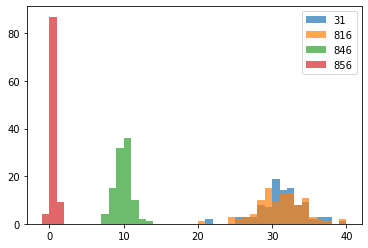

In [223]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [196]:
def get_pred(tss, forecasts, idx):
    rec = np.zeros((3))
    rec[0] = list(tss[idx].values)[0]
    truth = int(scaler.inverse_transform(rec)[0])
    
    ret = []
    for sample in forecasts[idx].samples:
        rec[0] = sample
        ret.append(int(scaler.inverse_transform(rec)[0]))    
        
    print('idx:', idx, 't:', truth, 'p:', int(np.mean(ret)))
    plt.hist(ret, bins=range(min(ret),max(ret)+1), alpha=0.7, label='%s'%idx)
    return truth, ret

def run_test(tss, forecasts, testlist):
    for idx in testlist:
        get_pred(tss, forecasts, idx)
    plt.legend()

In [104]:
trec = next(iter(train_ds))
trec


{'target': array([1.46169051]), 'feat': array([-0.64173227, -1.57348481])}

idx: 31 t: 31 p: 30
idx: 816 t: 44 p: 29
idx: 846 t: 14 p: 6
idx: 856 t: 4 p: 0


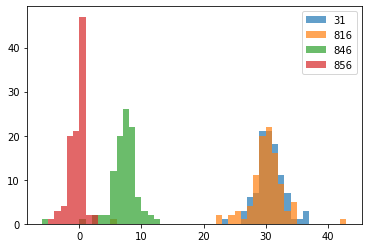

In [197]:
run_test(tss, forecasts, [31,816,846,856])

In [165]:
test_sel.iloc[816]

lap2nextpit      44.0
caution_laps      0.0
pitage            0.0
pit_oncaution     0.0
carno            12.0
eid               5.0
lap              49.0
stint_len        44.0
Name: 1077, dtype: float64

In [171]:
test_sel.iloc[836]

lap2nextpit      24.0
caution_laps     12.0
pitage           20.0
pit_oncaution     0.0
carno            12.0
eid               5.0
lap              69.0
stint_len        44.0
Name: 1097, dtype: float64

In [235]:
t[mid],s[mid] = eval_model(pm)

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 205.30it/s]

{
    "MSE": 0.6918114296565665,
    "abs_error": 2726.1717866286026,
    "abs_target_sum": 3677.5622829723397,
    "abs_target_mean": 1.0108747341870092,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6370308383276133,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2926.728351150853,
    "Coverage[0.1]": 0.44887300714678396,
    "QuantileLoss[0.5]": 2726.1717866286026,
    "Coverage[0.5]": 0.5104452996151732,
    "QuantileLoss[0.9]": 1433.9767268862302,
    "Coverage[0.9]": 0.7344694887300715,
    "RMSE": 0.8317520241373426,
    "NRMSE": 0.8228042466668978,
    "ND": 0.7412986040375668,
    "wQuantileLoss[0.1]": 0.7958337958549446,
    "wQuantileLoss[0.5]": 0.7412986040375668,
    "wQuantileLoss[0.9]": 0.38992588474320494,
    "mean_wQuantileLoss": 0.6423527615452388,
    "MAE_Coverage": 0.17494960601062856
}


idx: 816 t: 44 p: 37


(44,
 [16,
  35,
  35,
  35,
  25,
  62,
  25,
  16,
  35,
  62,
  25,
  35,
  44,
  16,
  35,
  72,
  44,
  44,
  53,
  25,
  44,
  44,
  25,
  35,
  53,
  44,
  25,
  35,
  35,
  25,
  53,
  44,
  44,
  35,
  25,
  35,
  35,
  25,
  53,
  16,
  81,
  44,
  44,
  35,
  35,
  44,
  16,
  44,
  25,
  35,
  25,
  35,
  25,
  72,
  16,
  16,
  53,
  35,
  44,
  44,
  35,
  25,
  16,
  53,
  16,
  53,
  25,
  62,
  35,
  44,
  35,
  16,
  44,
  16,
  44,
  72,
  25,
  53,
  35,
  25,
  44,
  44,
  62,
  53,
  35,
  16,
  72,
  25,
  35,
  35,
  25,
  44,
  25,
  25,
  35,
  44,
  53,
  25,
  25,
  25])

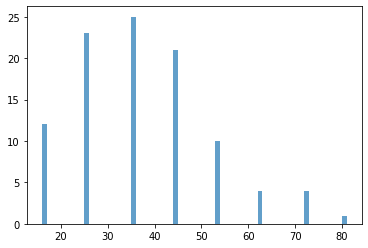

In [238]:
get_pred(t[mid],s[mid], 816)